# Molecular and cell line covariates

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from math import ceil
from time import time

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.analysis.sublineage_model_analysis import (
    get_sgrna_to_gene_map,
    load_sublineage_model_posteriors,
    sublineage_to_lineage_map,
)
from speclet.data_processing.common import head_tail
from speclet.data_processing.crispr import grouped_copy_number_transform
from speclet.io import DataFile, data_path, notebook_output_and_stash_dirs
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

In [5]:
OUTPUT_DIR, STASH_DIR = notebook_output_and_stash_dirs(
    "100_106_molecular-cellular-covariates"
)

### Data

#### Model posteriors

In [6]:
postmen = load_sublineage_model_posteriors()

In [7]:
postmen.keys

['bile duct (cholangiocarcinoma)',
 'bile duct (gallbladder adenocarcinoma)',
 'blood (ALL)',
 'blood (AML)',
 'blood (CLL)',
 'blood (CML)',
 'bone (Ewing sarcoma)',
 'bone (chordoma)',
 'bone (osteosarcoma)',
 'breast',
 'central nervous system (glioma)',
 'central nervous system (medulloblastoma)',
 'cervix (cervical carcinoma)',
 'cervix (cervical squamous)',
 'colorectal',
 'esophagus (esophagus adenocarcinoma)',
 'esophagus (esophagus squamous)',
 'eye (uveal melanoma)',
 'gastric (gastric adenocarcinoma)',
 'kidney (renal cell carcinoma)',
 'liver (hepatocellular carcinoma)',
 'lung (NSCLC)',
 'lung (SCLC)',
 'lung (mesothelioma)',
 'lymphocyte (hodgkin lymphoma)',
 'lymphocyte (lymphoma unspecified)',
 'lymphocyte (non hodgkin lymphoma)',
 'ovary (ovary adenocarcinoma)',
 'pancreas',
 'peripheral nervous system (neuroblastoma)',
 'plasma cell (multiple myeloma)',
 'prostate',
 'skin (melanoma)',
 'skin (skin squamous)',
 'soft tissue (ATRT)',
 'soft tissue (liposarcoma)',
 'sof

In [8]:
len(postmen)

43

In [9]:
sub_to_lineage, lineages = sublineage_to_lineage_map(postmen)

In [10]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

### sgRNA information

In [11]:
sgrna_info = get_sgrna_to_gene_map()
sgrna_info.head()

sgrna hugo_symbol sgrna_target_chr  sgrna_target_pos
0  GGAAGTCTGGAGTCTCCAGG        A1BG               19          58353109
1  GTGGACTTCCAGCTACGGCG        A1BG               19          58351569
2  GTGTGCCGAGGTGTGCTGCG        A1BG               19          58352467
3  TCAATGGTCACAGTAGCGCT        A1BG               19          58352307
4  GCAGATAAAACCAAAAACCG        A1CF               10          50836144

### Gene-to-chromosome map

In [12]:
gene_chr_map = (
    sgrna_info.drop(columns=["sgrna"])
    .drop_duplicates()
    .groupby(["hugo_symbol", "sgrna_target_chr"])["sgrna_target_pos"]
    .median()
    .reset_index()
)
assert gene_chr_map["hugo_symbol"].nunique() == len(gene_chr_map)
gene_chr_map.head()

hugo_symbol sgrna_target_chr  sgrna_target_pos
0        A1BG               19        58352387.0
1        A1CF               10        50840175.0
2         A2M               12         9104546.5
3       A2ML1               12         8835899.5
4     A3GALT2                1        33312702.5

### Known essential genes

In [13]:
essential_genes = set(
    pd.read_csv(data_path(DataFile.DEPMAP_ESSENTIALS))
    .query("is_essential")["gene"]
    .unique()
)
len(essential_genes)

1248

## Analysis

In [14]:
def get_variables_posterior_summary(
    pm: PostDataMan, var_names: list[str], stash: bool = True
) -> pd.DataFrame:
    vnames = "-".join(var_names)
    stash_fp = STASH_DIR / f"posterior-summary-df_{pm.id}_var-{vnames}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    try:
        post = (
            pm.posterior_summary.copy()
            .filter_column_isin("var_name", var_names)
            .reset_index(drop=True)
            .assign(lineage_subtype=pm.id)
        )
    except FileNotFoundError:
        print(f"No posterior summary for '{pm.id}'.")
        return pd.DataFrame()
    post.to_csv(stash_fp, index=False)
    return post

In [15]:
def map_subtype_to_lineage(
    df: pd.DataFrame,
    st_map: dict[str, str],
    st_col: str = "lineage_subtype",
    line_col: str = "lineage",
) -> pd.DataFrame:
    df[line_col] = df[st_col].map(st_map)
    return df

### Gene copy number and RNA effects

In [16]:
def _get_rna_and_copynumber_effects(
    pm: PostDataMan, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"cn-rna-posterior-summaries_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    post = get_variables_posterior_summary(pm, var_names=["b", "d"])
    if len(post) == 0:
        return post
    post = post.pipe(
        extract_coords_param_names, col="parameter", names=["hugo_symbol"]
    ).assign(lineage_subtype=pm.id)
    post.to_csv(stash_fp, index=False)
    return post

In [17]:
rna_cn_posterior = (
    pd.concat([_get_rna_and_copynumber_effects(pm) for pm in postmen.posteriors])
    .reset_index(drop=True)
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
    .merge(gene_chr_map, on="hugo_symbol", how="left")
)
rna_cn_posterior.head(5)

No posterior summary for 'skin (melanoma)'.


parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     b[A1BG] -0.002  0.029    -0.049      0.044        0.0    0.001   
1     b[A1CF]  0.033  0.030    -0.015      0.080        0.0    0.000   
2      b[A2M]  0.032  0.030    -0.015      0.081        0.0    0.000   
3    b[A2ML1]  0.007  0.031    -0.042      0.055        0.0    0.001   
4  b[A3GALT2] -0.051  0.031    -0.101     -0.004        0.0    0.000   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0    9778.0    3024.0    1.0        b  bile duct (cholangiocarcinoma)   
1   10302.0    2669.0    1.0        b  bile duct (cholangiocarcinoma)   
2    9712.0    2656.0    1.0        b  bile duct (cholangiocarcinoma)   
3   12171.0    2759.0    1.0        b  bile duct (cholangiocarcinoma)   
4   10082.0    2664.0    1.0        b  bile duct (cholangiocarcinoma)   

  hugo_symbol    lineage sgrna_target_chr  sgrna_target_pos  
0        A1BG  bile duct               19        58352387.0  
1        A1CF  bile duct               10        50840175.0  
2         A2M  bile duct               12         9104546.5  
3       A2ML1  bile duct               12         8835899.5  
4     A3GALT2  bile duct                1        33312702.5

In [18]:
rna_cn_posterior.to_csv(
    OUTPUT_DIR / "rna-copynumber-posterior-summaries.csv", index=False
)

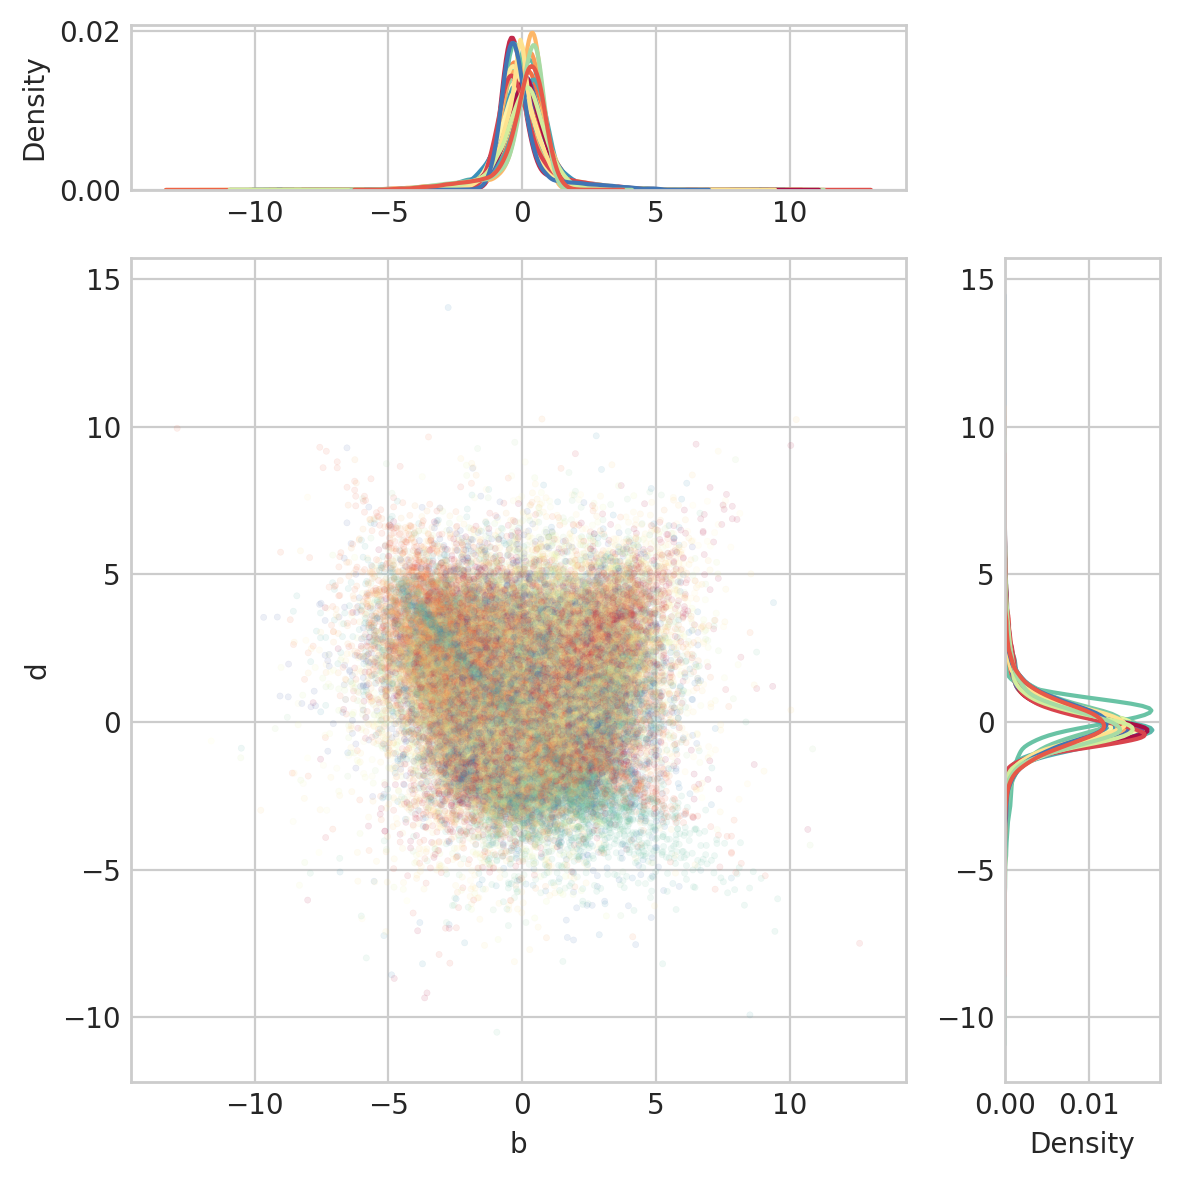

In [19]:
def _z_scale_bd(df: pd.DataFrame) -> pd.DataFrame:
    for x in ["b", "d"]:
        df[x] = (df[x] - df[x].mean()) / df[x].std()
    return df


rna_cn_posterior_pivot = (
    rna_cn_posterior.pivot_wider(
        ["hugo_symbol", "lineage", "lineage_subtype"],
        names_from="var_name",
        values_from="mean",
    )
    .groupby(["lineage_subtype"])
    .apply(_z_scale_bd)
    .sample(frac=1)
)

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=(5, 1), height_ratios=(1, 5))
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

sns.scatterplot(
    data=rna_cn_posterior_pivot,
    x="b",
    y="d",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax,
    s=5,
    alpha=0.1,
    edgecolor=None,
    legend=False,
)

sns.kdeplot(
    data=rna_cn_posterior_pivot,
    x="b",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax_histx,
    legend=False,
)
ax_histx.set_xlabel(None)

sns.kdeplot(
    data=rna_cn_posterior_pivot,
    y="d",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax_histy,
    legend=False,
)
ax_histy.set_ylabel(None)

fig.tight_layout()
plt.show()

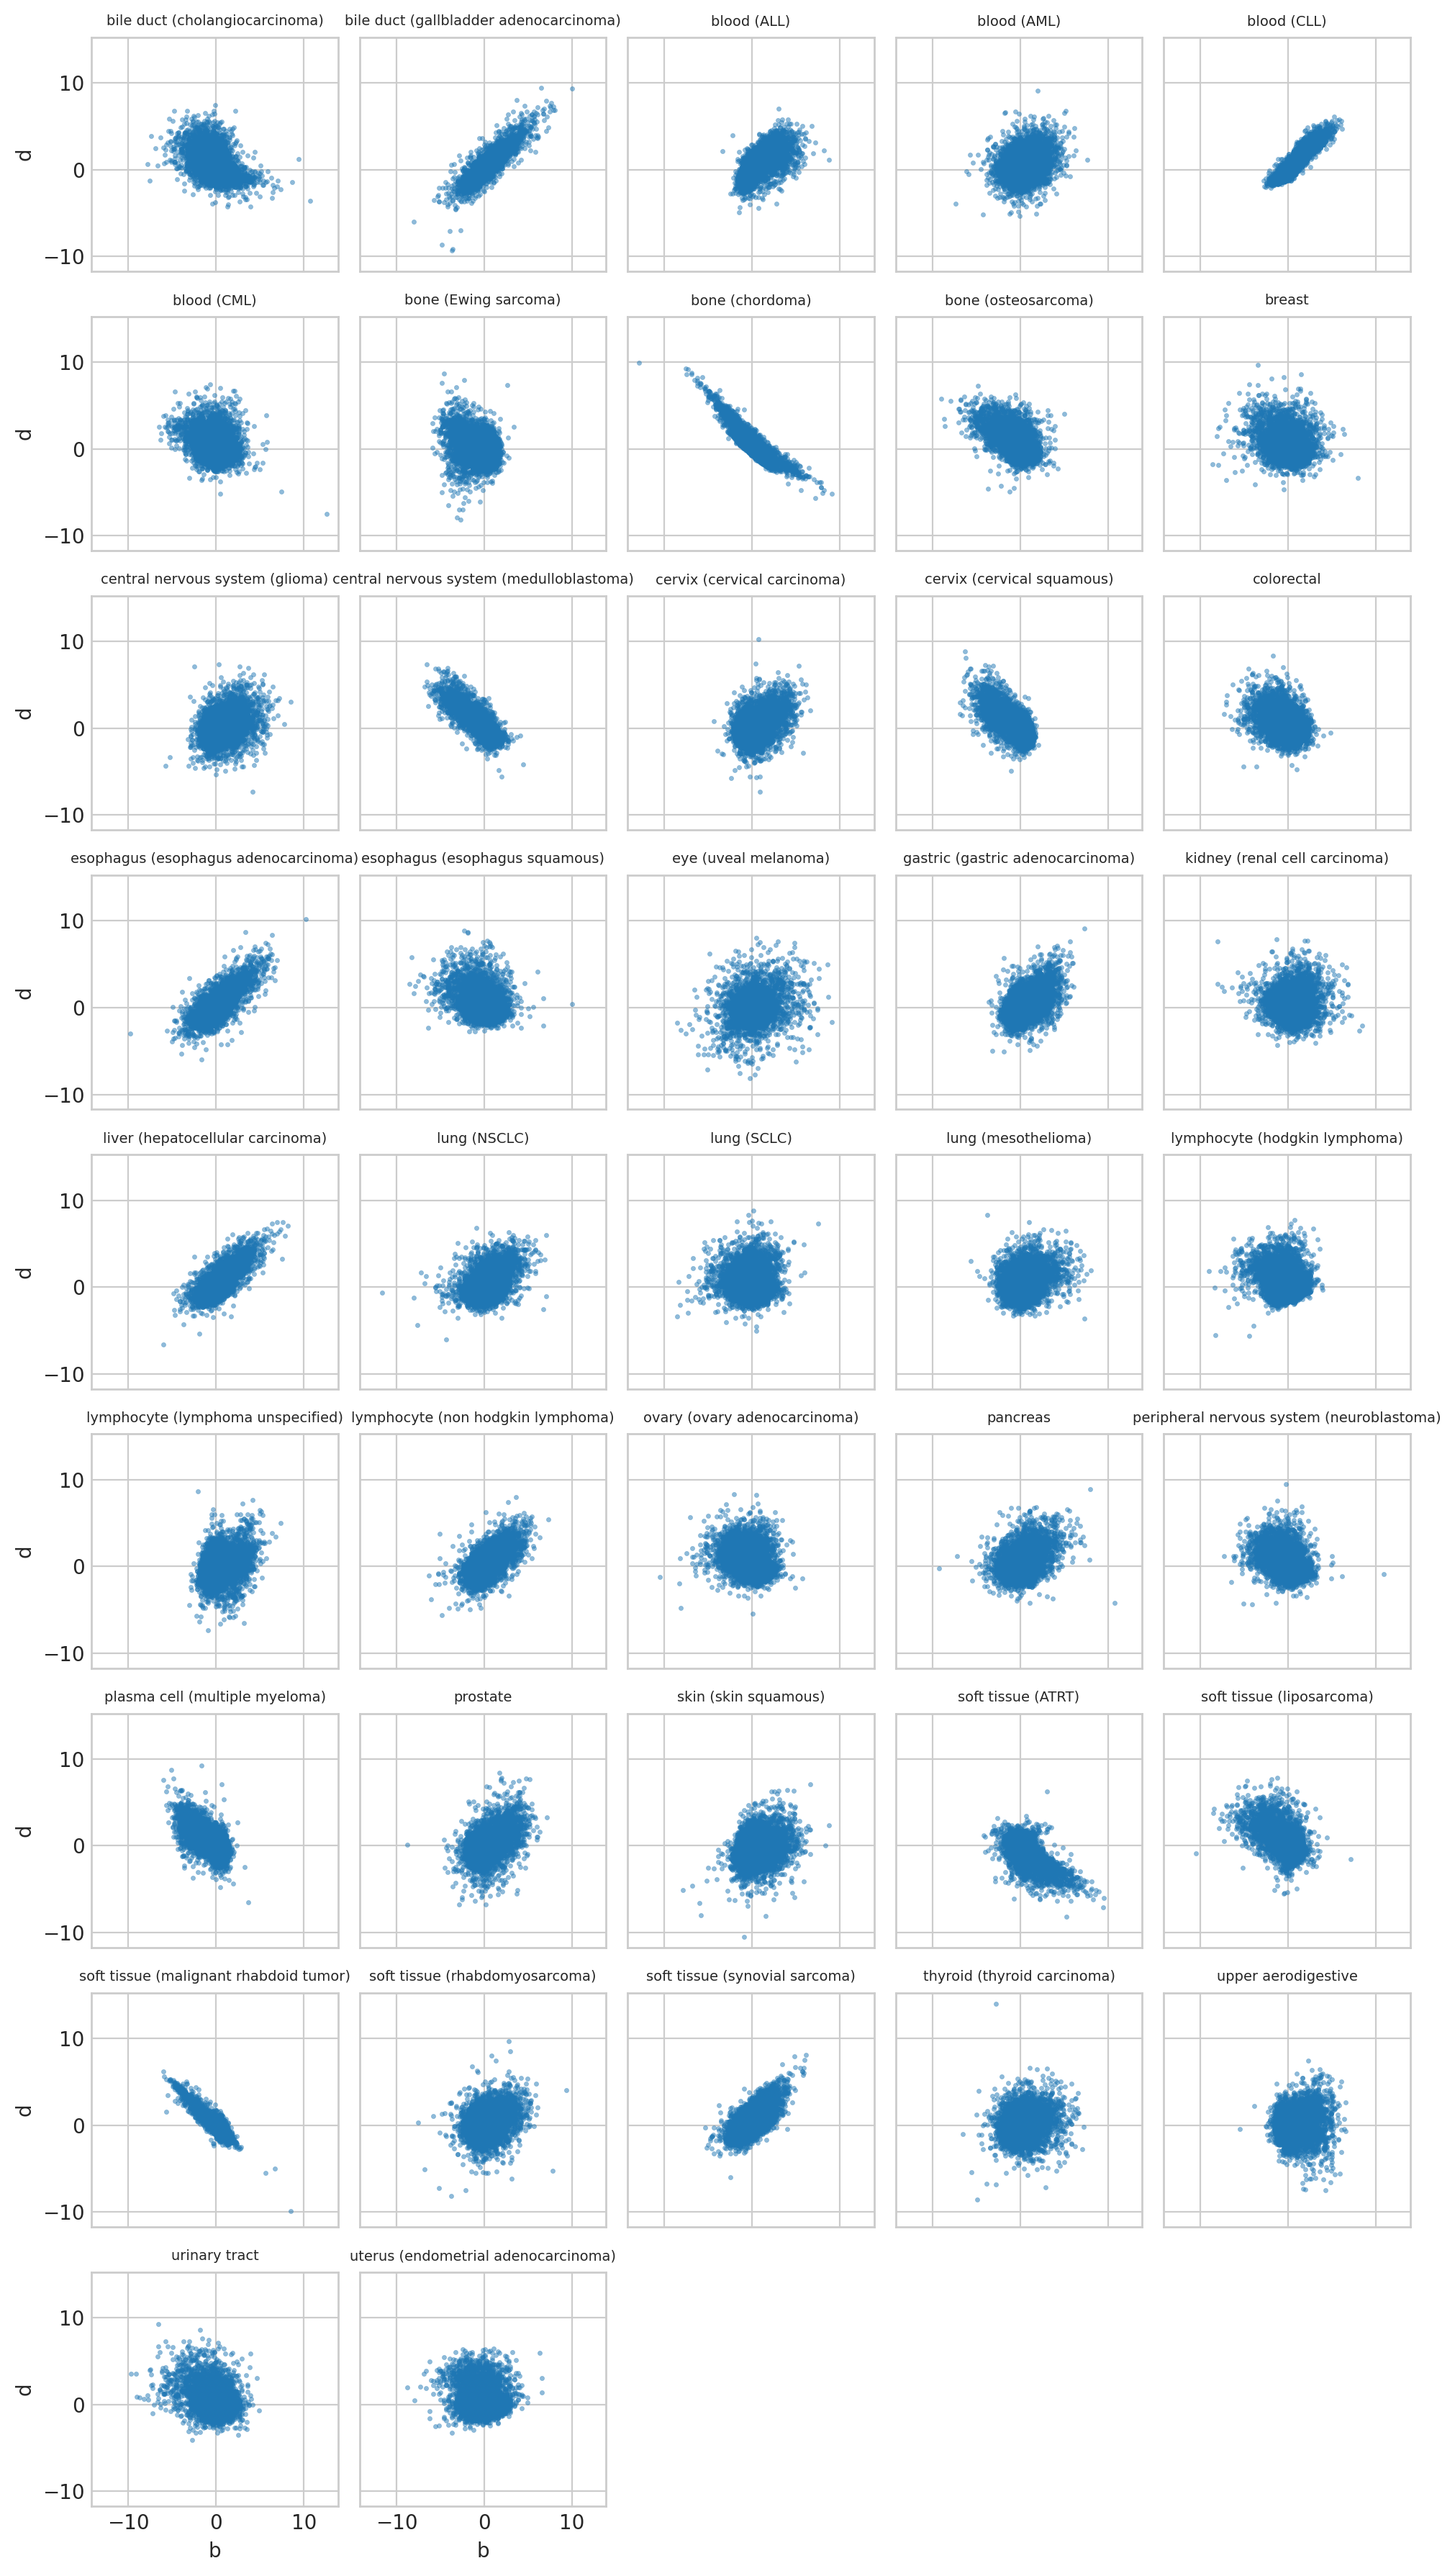

In [20]:
n_sublines = rna_cn_posterior_pivot["lineage_subtype"].nunique()
ncols = 5
nrows = ceil(n_sublines / ncols)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2 * nrows), sharex=True, sharey=True
)
for ax, (st, data_st) in zip(
    axes.flatten(), rna_cn_posterior_pivot.groupby(["lineage_subtype"])
):
    ax.set_title(st, size=7)
    sns.scatterplot(data=data_st, x="b", y="d", ax=ax, s=5, alpha=0.5, edgecolor=None)

for ax in axes.flatten()[n_sublines:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

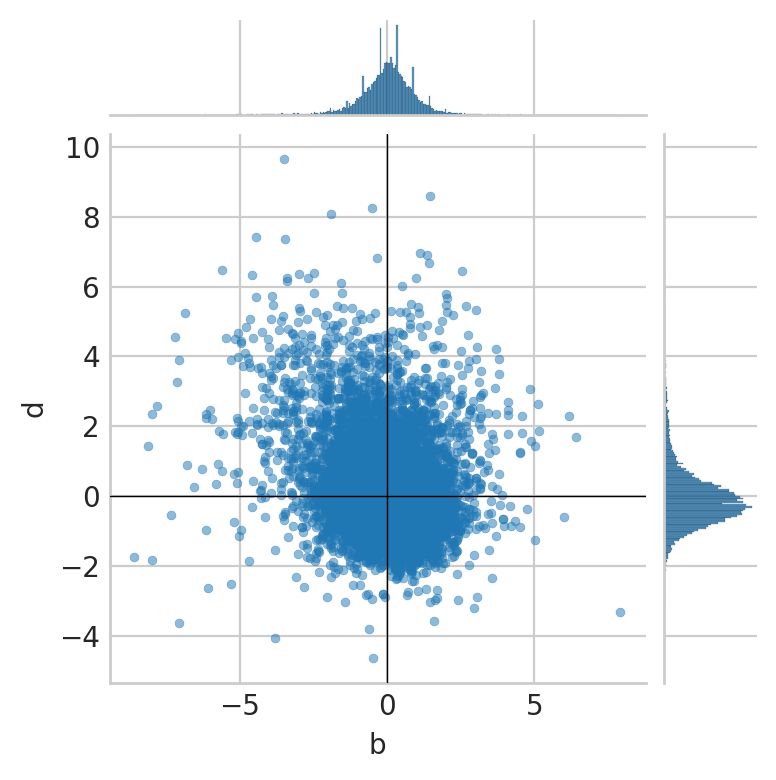

In [21]:
plt_df = rna_cn_posterior_pivot.query("lineage_subtype == 'breast'").reset_index(
    drop=True
)
jp = sns.jointplot(
    data=plt_df,
    x="b",
    y="d",
    marginal_kws={"binwidth": 0.05},
    edgecolor=None,
    alpha=0.5,
    s=10,
    height=4,
    zorder=10,
)
ax = jp.ax_joint
ax.axhline(0, c="k", lw=0.5, zorder=20)
ax.axvline(0, c="k", lw=0.5, zorder=20)
plt.show()

In [22]:
def _get_copy_number_data(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"copy-number-median_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    res = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            usecols=["hugo_symbol", "depmap_id", "copy_number"],
        )
        .assign(copy_number_adj=lambda d: (2 ** d["copy_number"]) - 1)
        .compute()
        .assign(lineage_subtype=pm.id)
    )
    res.to_csv(stash_fp, index=False)
    return res

In [23]:
TEST_CHR = "2"
lung_df = (
    rna_cn_posterior.query(f"sgrna_target_chr == '{TEST_CHR}'")
    .filter_string("lineage_subtype", "lung")
    .reset_index(drop=True)
)

In [24]:
lung_cn_data = pd.concat(
    [
        _get_copy_number_data(postmen[st], stash=True)
        for st in lung_df["lineage_subtype"].unique()
    ]
).reset_index(drop=True)

In [25]:
lung_cn_data = lung_cn_data.pipe(
    grouped_copy_number_transform,
    group=["hugo_symbol", "lineage_subtype"],
    cn_col="copy_number",
    new_col="cn_gene",
    max_cn=3,
)

In [26]:
lung_gene_cn_mean = (
    lung_cn_data.groupby(["hugo_symbol", "lineage_subtype"])["cn_gene"]
    .mean()
    .reset_index(drop=False)
    .rename(columns={"cn_gene": "cn_gene_mean"})
)

In [27]:
def _moving_average_over_chrom(df: pd.DataFrame, w: int = 10) -> pd.DataFrame:
    df["y_avg"] = df["y"].rolling(w, center=True).median()
    return df

In [28]:
lung_df = (
    lung_df.merge(lung_gene_cn_mean, on=["hugo_symbol", "lineage_subtype"])
    .assign(y=lambda d: d["mean"] * d["cn_gene_mean"])
    .sort_values(["lineage_subtype", "sgrna_target_chr", "sgrna_target_pos"])
    .reset_index(drop=True)
    .groupby("lineage_subtype")
    .apply(_moving_average_over_chrom, w=100)
)

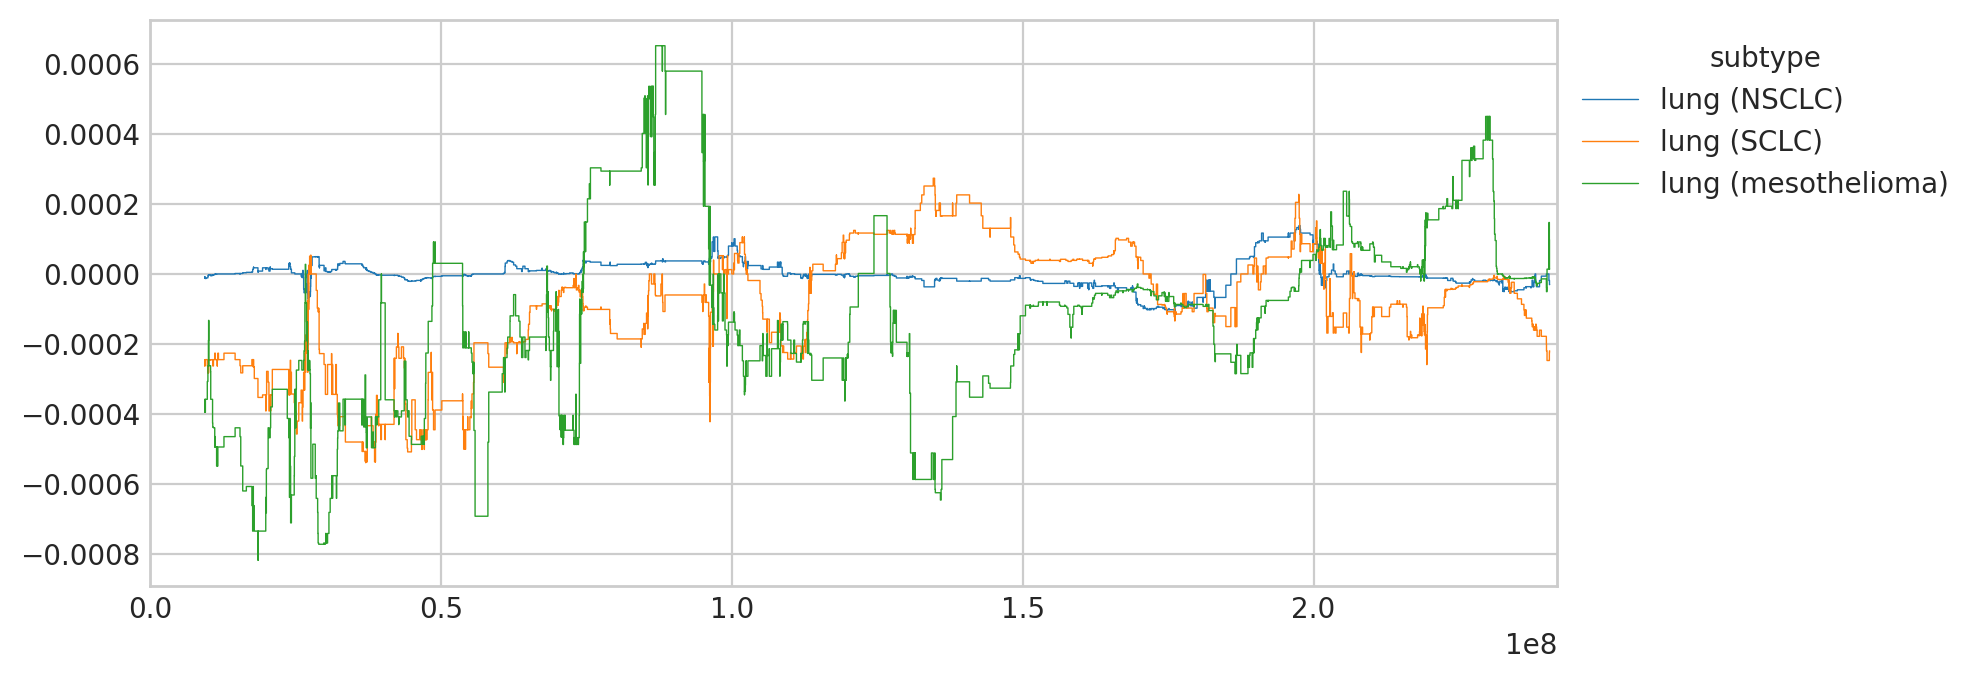

In [29]:
_, ax = plt.subplots(figsize=(10, 3.5))

for st, data_st in lung_df.groupby("lineage_subtype"):
    # ax.scatter(
    #     data_st["sgrna_target_pos"],
    #     data_st["y"],
    #     s=1,
    #     alpha=0.1,
    #     marker="o",
    #     edgecolor=None,
    #     label=st,
    # )
    ax.step(data_st["sgrna_target_pos"], data_st["y_avg"], lw=0.5, label=st)

# ax.set_ylim(-ylim * 1.02, ylim * 1.02)
ax.set_xlim(0, lung_df["sgrna_target_pos"].max())
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="subtype")
plt.tight_layout()
plt.show()

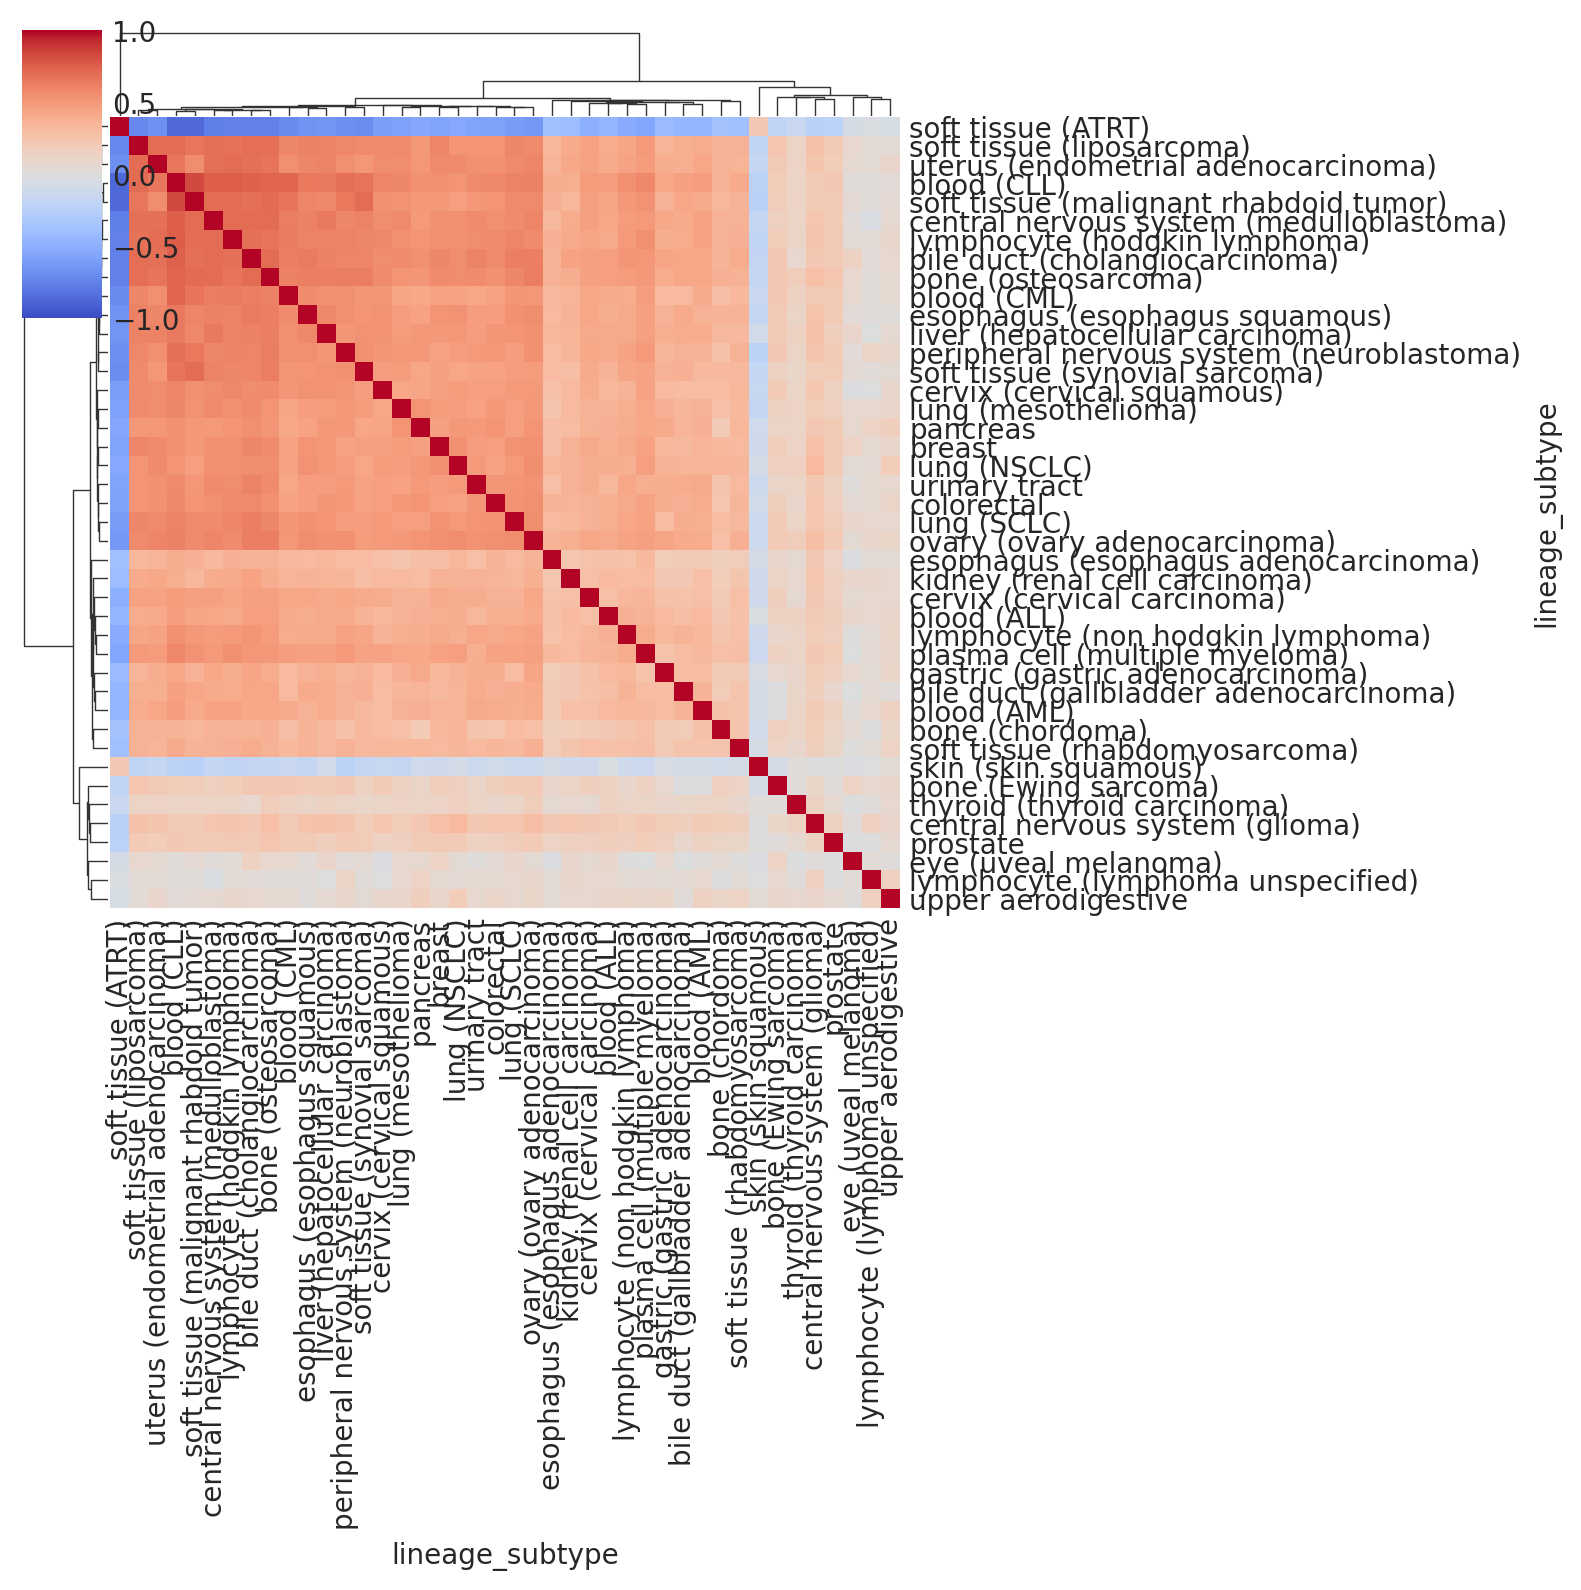

In [30]:
cn_matrix = (
    rna_cn_posterior.copy()
    .query("var_name == 'd'")
    .pivot_wider(["lineage_subtype"], names_from="hugo_symbol", values_from="mean")
    .set_index("lineage_subtype")
)

cn_variances = cn_matrix.var()
top_var_genes = cn_variances[cn_variances >= np.quantile(cn_variances, q=0.8)].index
cn_matrix = cn_matrix[top_var_genes]

sns.clustermap(
    cn_matrix.T.corr(),
    figsize=(8, 8),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    xticklabels=1,
    yticklabels=1,
)
plt.show()

In [31]:
def _assign_rank(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df.sort_values("mean")
        .reset_index(drop=True)
        .assign(rank=np.arange(len(df)) / len(df))
    )
    return df


ranked_genes = (
    rna_cn_posterior.groupby(["lineage_subtype", "var_name"])
    .apply(_assign_rank)
    .reset_index(drop=True)
)

total_ranked_genes = (
    ranked_genes.copy()
    .groupby(["hugo_symbol", "var_name"])["rank"]
    .median()
    .reset_index(drop=False)
    .sort_values(["var_name", "rank", "hugo_symbol"], ascending=(True, False, True))
    .reset_index(drop=True)
    .assign(is_essential=lambda d: d["hugo_symbol"].isin(essential_genes))
)
total_ranked_genes.head()

hugo_symbol var_name      rank  is_essential
0        LSM2        b  0.965865         False
1       HAUS4        b  0.959545          True
2       PSMG4        b  0.958221          True
3    TIMELESS        b  0.956344          True
4       SMC1A        b  0.953033          True

In [32]:
total_ranked_genes.groupby("var_name").pipe(head_tail, n=5).sort_values(
    ["var_name", "rank"]
)

hugo_symbol var_name      rank  is_essential
18118      TIPARP        b  0.055108         False
18117        MDM2        b  0.055163         False
18116       CCND1        b  0.058585         False
18115       CFLAR        b  0.061041         False
18114        CDK6        b  0.071141         False
4           SMC1A        b  0.953033          True
3        TIMELESS        b  0.956344          True
2           PSMG4        b  0.958221          True
1           HAUS4        b  0.959545          True
0            LSM2        b  0.965865         False
36237       CCND1        d  0.124676         False
36236      CDKN2B        d  0.152740         False
36235      SPRED2        d  0.152878         False
36234        SBF1        d  0.152906         False
36233       IGFL1        d  0.154699         False
18123        RPL6        d  0.986809         False
18122      DONSON        d  0.988382          True
18121        RPL4        d  0.989403          True
18120         RAN        d  0.991859          True
18119       RPS3A        d  0.991970         False

In [33]:
total_ranked_genes.to_csv(OUTPUT_DIR / "total-ranked-genes-copynumber.csv", index=False)

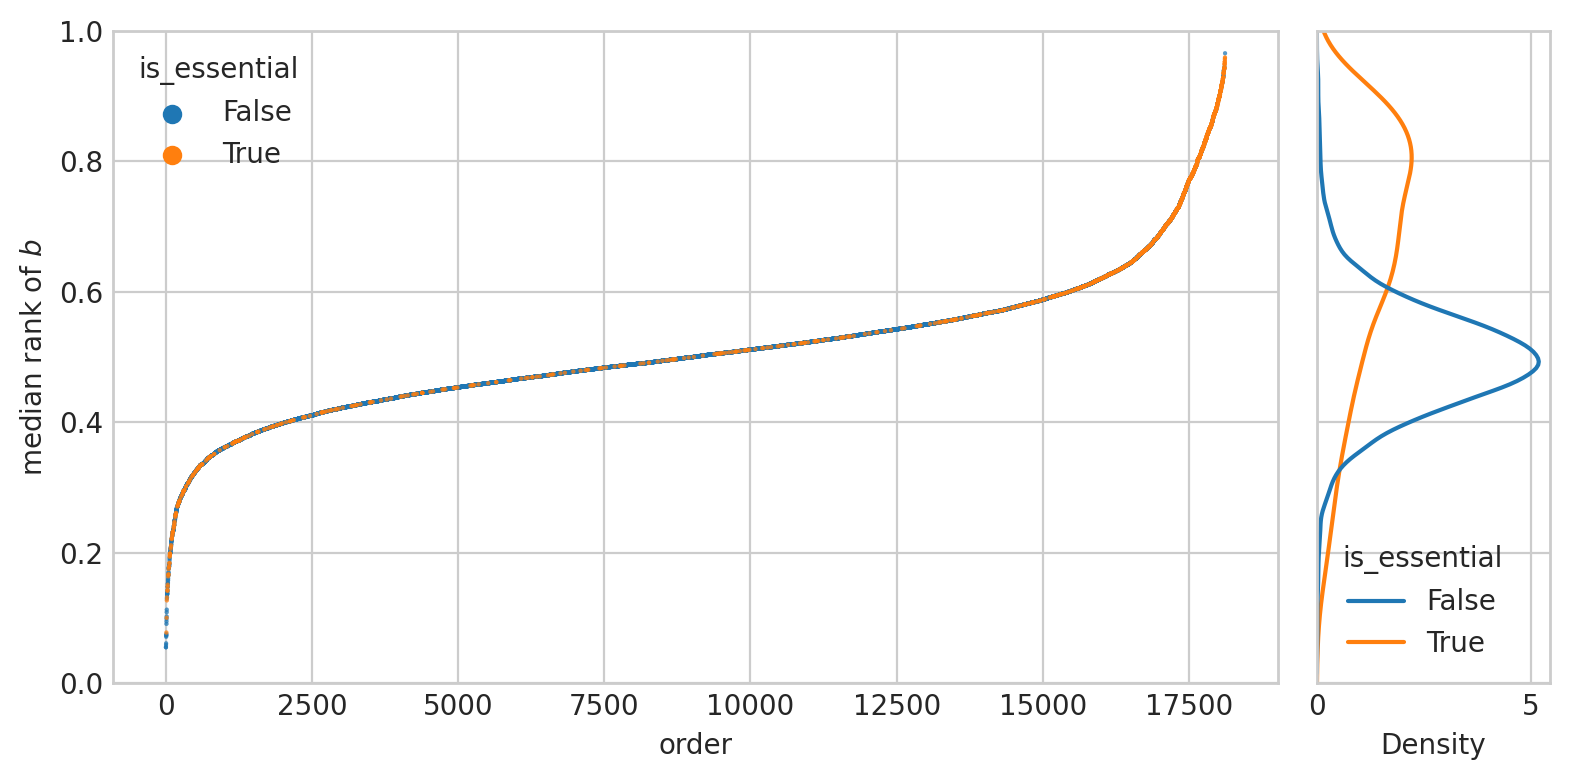

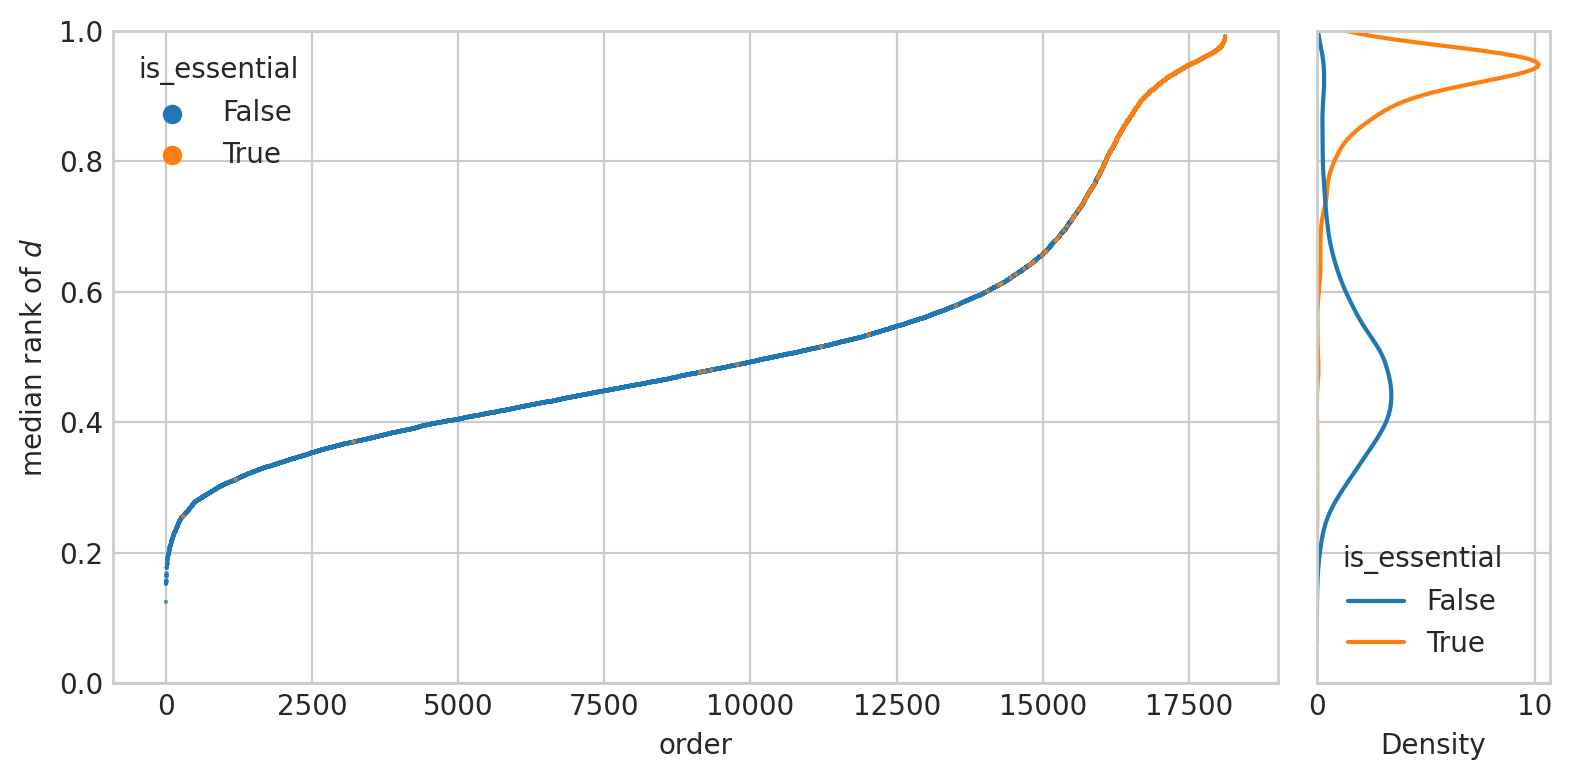

In [34]:
for v in ["b", "d"]:
    df = (
        total_ranked_genes.query(f"var_name == '{v}'")
        .sort_values("rank", ascending=True)
        .assign(order=lambda d: np.arange(len(d)))
        .sort_values("is_essential")
    )

    fig, axes = plt.subplots(
        ncols=2, figsize=(8, 4), sharey=True, gridspec_kw={"width_ratios": (5, 1)}
    )

    sns.scatterplot(
        data=df,
        x="order",
        y="rank",
        hue="is_essential",
        edgecolor=None,
        s=2,
        alpha=0.75,
        ax=axes[0],
    )
    sns.kdeplot(data=df, y="rank", hue="is_essential", common_norm=False, ax=axes[1])
    axes[0].set_ylabel(f"median rank of ${v}$")
    axes[0].set_ylim(0, 1)
    fig.tight_layout()
    plt.show()

In [35]:
cn_total_ranked_genes = total_ranked_genes.query(f"var_name == '{v}'").assign(
    is_essential=lambda d: d["hugo_symbol"].isin(essential_genes)
)

essentials_cutoff = np.quantile(
    cn_total_ranked_genes.query("is_essential")["rank"], 0.9
)
print(f"essential 90% cut-off: {essentials_cutoff:0.4f}")
new_essential_genes = cn_total_ranked_genes.query(
    f"not is_essential and rank > {essentials_cutoff}"
).reset_index(drop=True)
new_essential_genes

essential 90% cut-off: 0.9684


hugo_symbol var_name      rank  is_essential
0        RPS3A        d  0.991970         False
1         RPL6        d  0.986809         False
2        RBM8A        d  0.986727         False
3         RPSA        d  0.985595         False
4        RPL14        d  0.985264         False
5        RPL34        d  0.984961         False
6        RPL17        d  0.984823         False
7        HSPE1        d  0.983305         False
8         RPS7        d  0.982643         False
9        RPL7A        d  0.982284         False
10        RRN3        d  0.981815         False
11    ATP6V1B2        d  0.981097         False
12       SRSF3        d  0.980490         False
13       SF3B5        d  0.980021         False
14       RPL23        d  0.979717         False
15       RPL24        d  0.979579         False
16        RPL7        d  0.978862         False
17       ESPL1        d  0.978669         False
18       SF3B4        d  0.978172         False
19      EXOSC6        d  0.977924         False
20      RPS27A        d  0.976461         False
21      SNRPA1        d  0.976130         False
22         DUT        d  0.976075         False
23      SNRPD1        d  0.975964         False
24       CIAO3        d  0.975799         False
25      SS18L2        d  0.975551         False
26     SNRNP25        d  0.974336         False
27     RSL24D1        d  0.974254         False
28       RPS17        d  0.974226         False
29        LSM8        d  0.974033         False
30       PSMA6        d  0.973812         False
31       MAK16        d  0.973646         False
32       PHF5A        d  0.973039         False
33     CFAP298        d  0.972653         False
34       SNRPG        d  0.972487         False
35       LETM1        d  0.972322         False
36        SBDS        d  0.972046         False
37       RPS24        d  0.971825         False
38       RBM22        d  0.971549         False
39       PSMA4        d  0.971466         False
40      DPAGT1        d  0.971411         False
41       CAPZB        d  0.971384         False
42       PSMC2        d  0.971273         False
43      SNAPC5        d  0.970804         False
44       GTF3A        d  0.970363         False
45       RPS19        d  0.970142         False
46        LSM2        d  0.969893         False
47       DHX37        d  0.969866         False
48       EIF3G        d  0.969728         False
49       CDCA8        d  0.969673         False
50       MED11        d  0.969673         False
51         FAU        d  0.969148         False

In [36]:
new_essentials_annotations = {
    "ATP6V1B2": "mitochondrial",
    "ANAPC2": "cell cycle",
    "ATP6V1F": "mitochondrial",
    "CAPZB": "cytoskeleton",
    "CDC27": "cell cycle",
    "CDCA8": "cell cycle",
    "CFAP298": "cilium",
    "CIAO3": "mitochondrial",
    "DHX37": "mitochondrial",
    "DPAGT1": "metabolism",
    "DUT": "mitochondrial",
    "EIF3E": "translation",
    "EIF3G": "translation",
    "ESPL1": "cell cycle",
    "EXOSC6": "exosome",
    "FAU": "ribosomal",
    "GTF3A": "transcription",
    "HSPE1": "mitochondrial",
    "KRT8": "cytoskeleton",
    "LETM1": "mitochondrial",
    "LSM2": "splicing",
    "LSM7": "splicing",
    "LSM8": "splicing",
    "MAK16": "translation",
    "MED11": "transcription",
    "PAM16": "mitochondrial",
    "PHF5A": "transcription",
    "PSMA4": "proteasome",
    "PSMA6": "proteasome",
    "PSMB3": "proteasome",
    "PSMC2": "proteasome",
    "RBM22": "splicing",
    "RBM8A": "splicing",
    "RPL14": "ribosomal",
    "RPL17": "ribosomal",
    "RPL23": "ribosomal",
    "RPL24": "ribosomal",
    "RPL32": "ribosomal",
    "RPL34": "ribosomal",
    "RPL5": "ribosomal",
    "RPL6": "ribosomal",
    "RPL7": "ribosomal",
    "RPL7A": "ribosomal",
    "RPS17": "ribosomal",
    "RPS19": "ribosomal",
    "RPS24": "ribosomal",
    "RPS27A": "ribosomal",
    "RPS28": "ribosomal",
    "RPS3A": "ribosomal",
    "RPS7": "ribosomal",
    "RPSA": "ribosomal",
    "RRN3": "transcription",
    "RSL24D1": "ribosomal",
    "SBDS": "translation",
    "SF3B4": "splicing",
    "SF3B5": "splicing",
    "SNAPC5": "splicing",
    "SNRNP25": "splicing",
    "SNRPA1": "splicing",
    "SNRPD1": "splicing",
    "SNRPG": "splicing",
    "SRSF3": "splicing",
    "SS18L2": "transcription",
    "UTP4": "splicing",
}

labels = sorted(list(set(new_essentials_annotations.values())))
new_essentials_pal = dict(zip(labels, sns.color_palette("icefire", len(labels))))
new_essentials_pal["essential"] = "grey"

In [37]:
_new_ess_genes = list(new_essentials_annotations.keys())
missing_anno = new_essential_genes[
    ~new_essential_genes["hugo_symbol"].isin(_new_ess_genes)
]["hugo_symbol"]
assert len(missing_anno) == 0, missing_anno

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


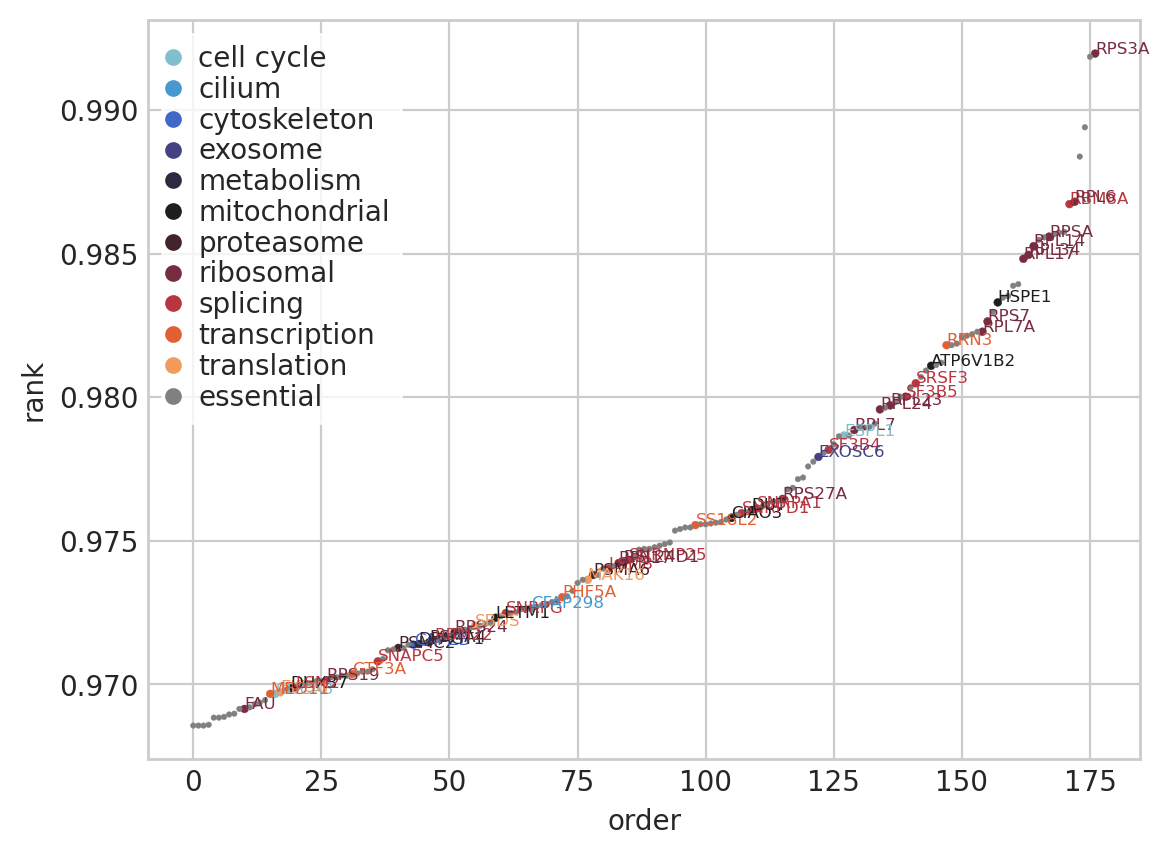

In [38]:
plot_df = (
    cn_total_ranked_genes.query(f"rank > {essentials_cutoff}")
    .reset_index(drop=True)
    .sort_values("rank", ascending=True)
    .assign(order=lambda d: np.arange(len(d)))
    .sort_values("is_essential")
    .assign(label=lambda d: d["hugo_symbol"].map(new_essentials_annotations))
    .fillna({"label": "essential"})
    .assign(
        label=lambda d: pd.Categorical(
            d["label"], categories=list(new_essentials_pal.keys()), ordered=True
        )
    )
    .reset_index(drop=True)
)

sizes = {True: 4, False: 8}

ax = sns.scatterplot(
    data=plot_df,
    x="order",
    y="rank",
    hue="label",
    size="is_essential",
    sizes=sizes,
    edgecolor=None,
    palette=new_essentials_pal,
    legend=False,
)

texts = []
for _, row in plot_df.iterrows():
    if not row["is_essential"]:
        txt = ax.text(
            row["order"],
            row["rank"],
            row["hugo_symbol"],
            size=6,
            color=new_essentials_pal[row["label"]],
        )
        texts.append(txt)
# adjust_text(texts, ax=ax, force_points=0, force_objects=0)

ax.legend(
    handles=pal_to_legend_handles(new_essentials_pal, lw=0, marker="o", markersize=5),
    loc="upper left",
    frameon=True,
    edgecolor="white",
    labelspacing=0.1,
    handletextpad=0.9,
    handlelength=0,
)
plt.show()

In [39]:
# Save components for figure.
plot_df.to_csv(OUTPUT_DIR / "new-essential-genes-plot-data.csv", index=False)
with open(OUTPUT_DIR / "new-essentials-pal.json", "w") as fp:
    json.dump(new_essentials_pal, fp)

In [40]:
def closest_distance_from_a_to_any_in_b(
    a: str, b: set[str], loc_df: pd.DataFrame
) -> float:
    chrom = loc_df[loc_df["hugo_symbol"] == a]["sgrna_target_chr"].values[0]
    others = loc_df.filter_column_isin("hugo_symbol", b).query(
        f"sgrna_target_chr == '{chrom}'"
    )
    if len(others) == 0:
        return np.nan
    loc = loc_df[loc_df["hugo_symbol"] == a]["sgrna_target_pos"].values[0]
    return np.min(np.abs(others["sgrna_target_pos"] - loc))

In [41]:
dist_to_essentials_stash_fp = STASH_DIR / "dist_to_essentials.csv"
if dist_to_essentials_stash_fp.exists():
    dist_to_essentials = pd.read_csv(dist_to_essentials_stash_fp)
else:
    _dist_to_essentials = []
    for g in gene_chr_map["hugo_symbol"]:
        d = closest_distance_from_a_to_any_in_b(g, essential_genes, gene_chr_map)
        _dist_to_essentials.append((g, d))

    dist_to_essentials = pd.DataFrame(
        _dist_to_essentials, columns=["hugo_symbol", "dist"]
    )
    dist_to_essentials.to_csv(dist_to_essentials_stash_fp, index=False)
dist_to_essentials.head()

hugo_symbol       dist
0        A1BG   200838.5
1        A1CF  7545767.5
2         A2M  2246746.0
3       A2ML1  1978099.0
4     A3GALT2   501977.5

<AxesSubplot:xlabel='dist', ylabel='Density'>

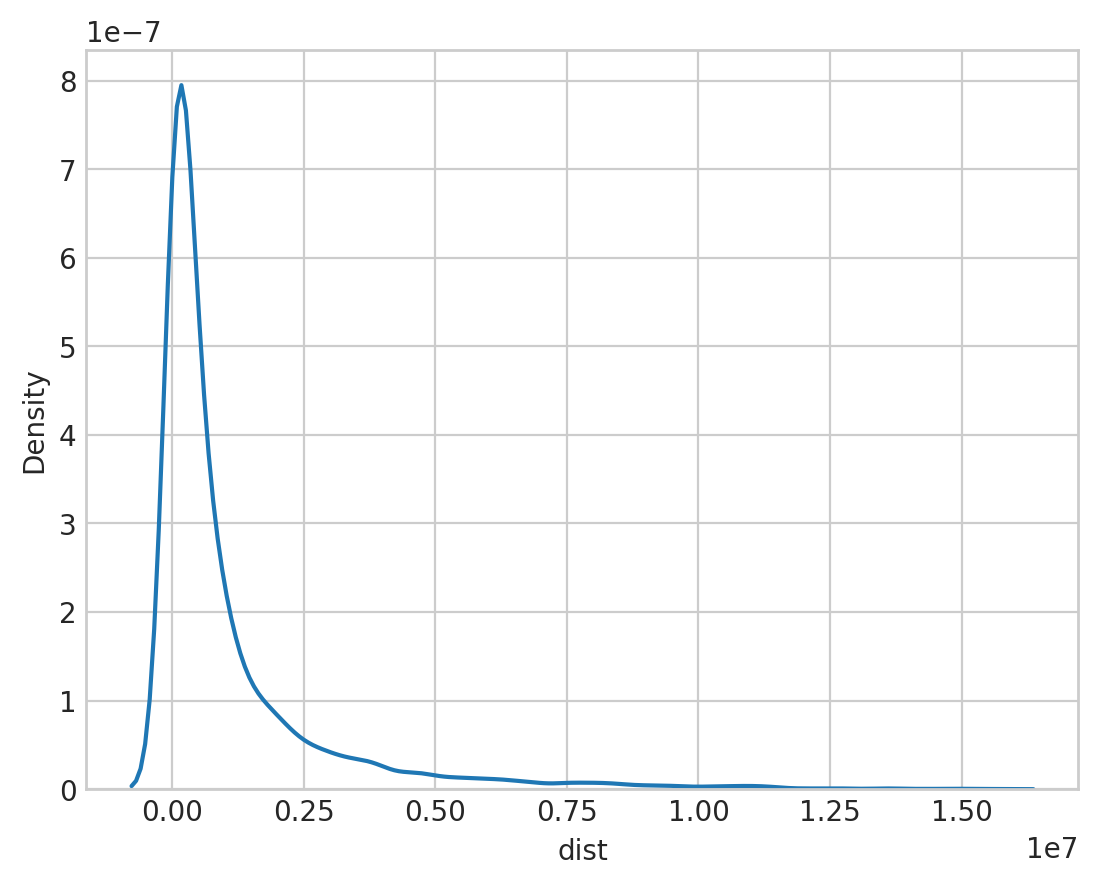

In [42]:
sns.kdeplot(dist_to_essentials["dist"])

In [43]:
lbls = []
for g in dist_to_essentials["hugo_symbol"]:
    if g in essential_genes:
        lbls.append("essential")
    elif g in set(new_essential_genes["hugo_symbol"]):
        lbls.append("new essential")
    else:
        lbls.append("other")

dist_to_essentials["gene_label"] = lbls

Do not seem to be closer to other essential genes than the other genes.

<AxesSubplot:xlabel='gene_label', ylabel='log_dist'>

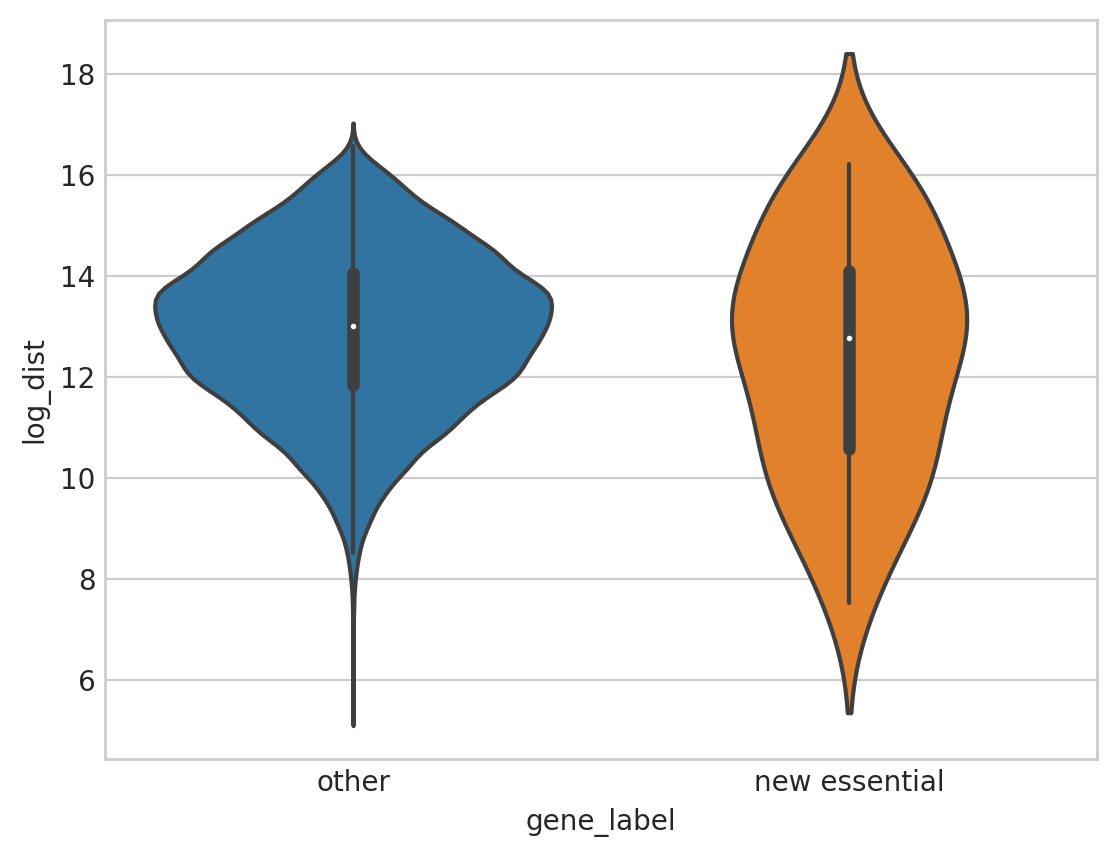

In [44]:
plt_df = dist_to_essentials.filter_column_isin(
    "hugo_symbol", essential_genes, complement=True
).assign(log_dist=lambda d: np.log(d["dist"]))
sns.violinplot(data=plt_df, x="gene_label", y="log_dist")

<AxesSubplot:xlabel='sgrna_target_pos', ylabel='mean'>

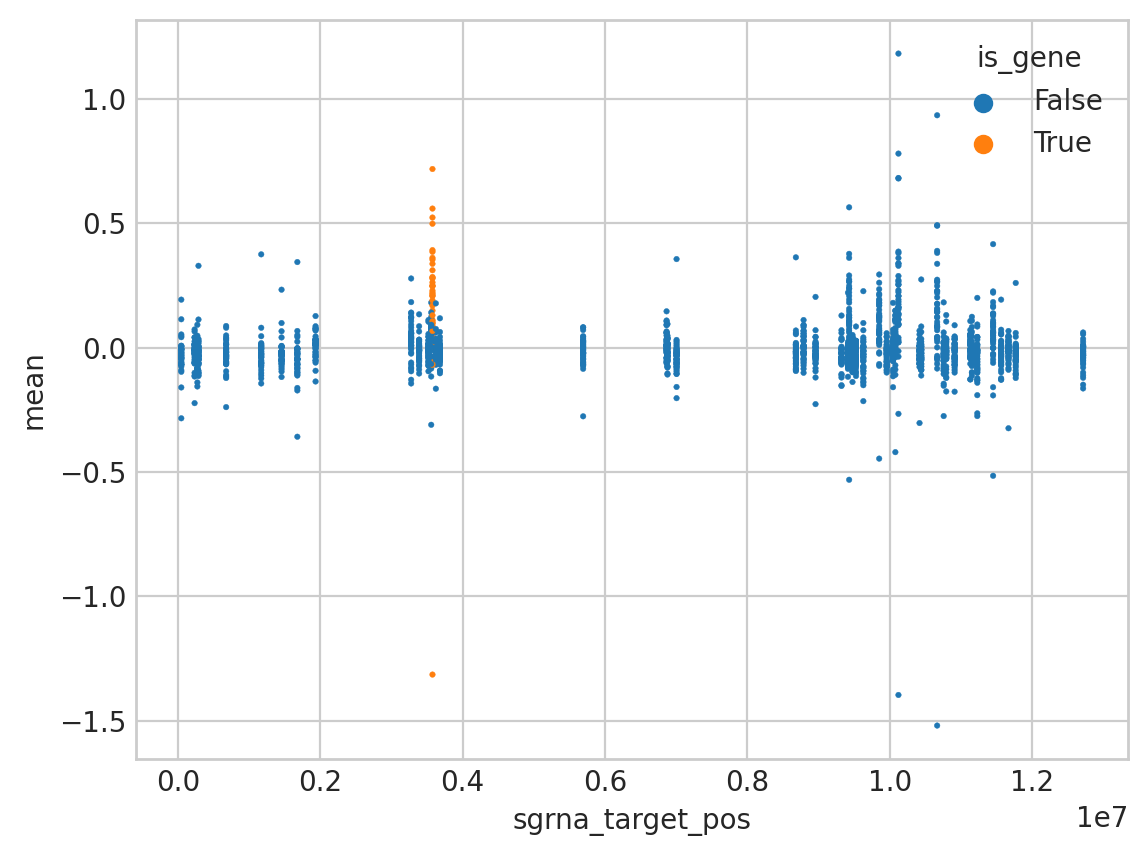

In [45]:
G = "RPS7"
gene_info = gene_chr_map.query(f"hugo_symbol == '{G}'")
gene_chr = gene_info["sgrna_target_chr"].values[0]
gene_loc = gene_info["sgrna_target_pos"].values[0]
dx = 1.0e7

neighbors = (
    gene_chr_map.query(f"sgrna_target_chr == '{gene_chr}'")
    .query(f"{gene_loc - dx} < sgrna_target_pos")
    .query(f"sgrna_target_pos < {gene_loc + dx}")
)

neighbors_cn_post = (
    rna_cn_posterior.query("var_name == 'd'")
    .filter_column_isin("hugo_symbol", neighbors["hugo_symbol"])
    .assign(is_gene=lambda d: d["hugo_symbol"] == G)
)

sns.scatterplot(
    data=neighbors_cn_post,
    x="sgrna_target_pos",
    y="mean",
    hue="is_gene",
    edgecolor=None,
    s=4,
)

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


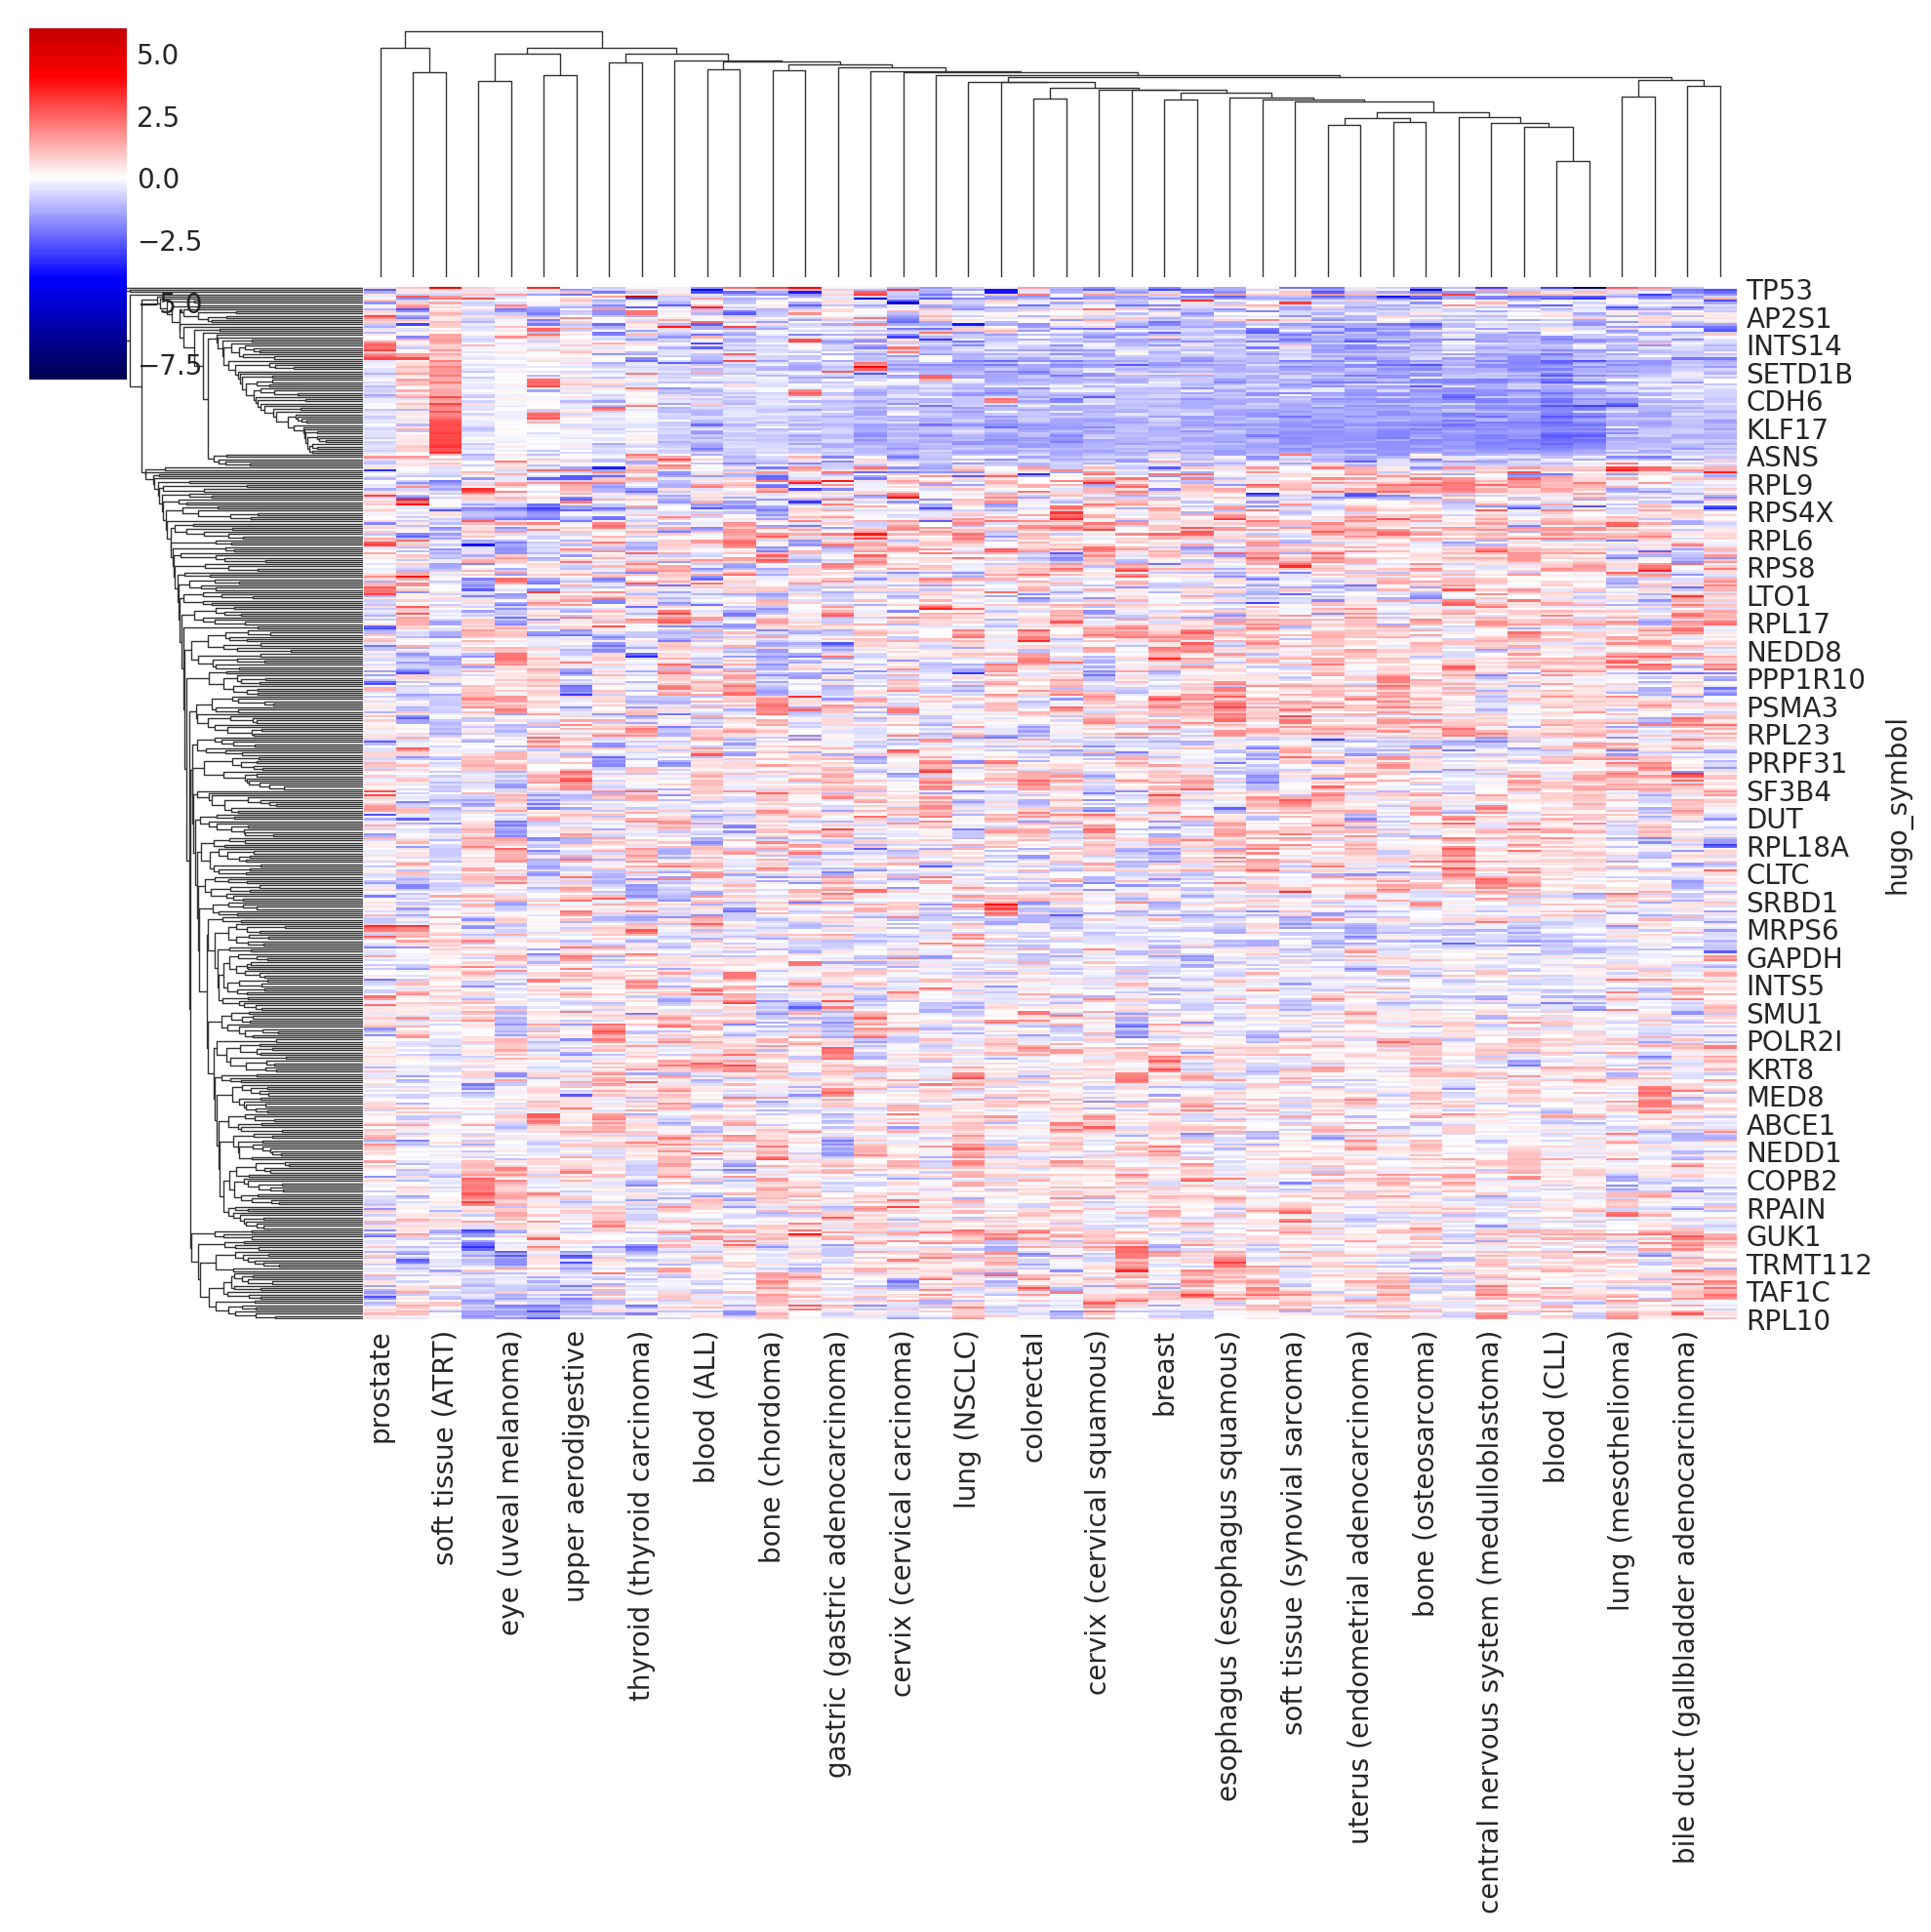

In [46]:
top_genes_per_subtype = (
    ranked_genes.sort_values(["lineage_subtype", "mean"], ascending=(True, False))
    .groupby("lineage_subtype")
    .head(20)
)

X = (
    rna_cn_posterior.query("var_name == 'd'")
    .filter_column_isin("hugo_symbol", top_genes_per_subtype["hugo_symbol"])
    .pivot_wider(["hugo_symbol"], names_from="lineage_subtype", values_from="mean")
    .set_index("hugo_symbol")
)

sns.clustermap(X, z_score=1, cmap="seismic", center=0)

variable: 'b'


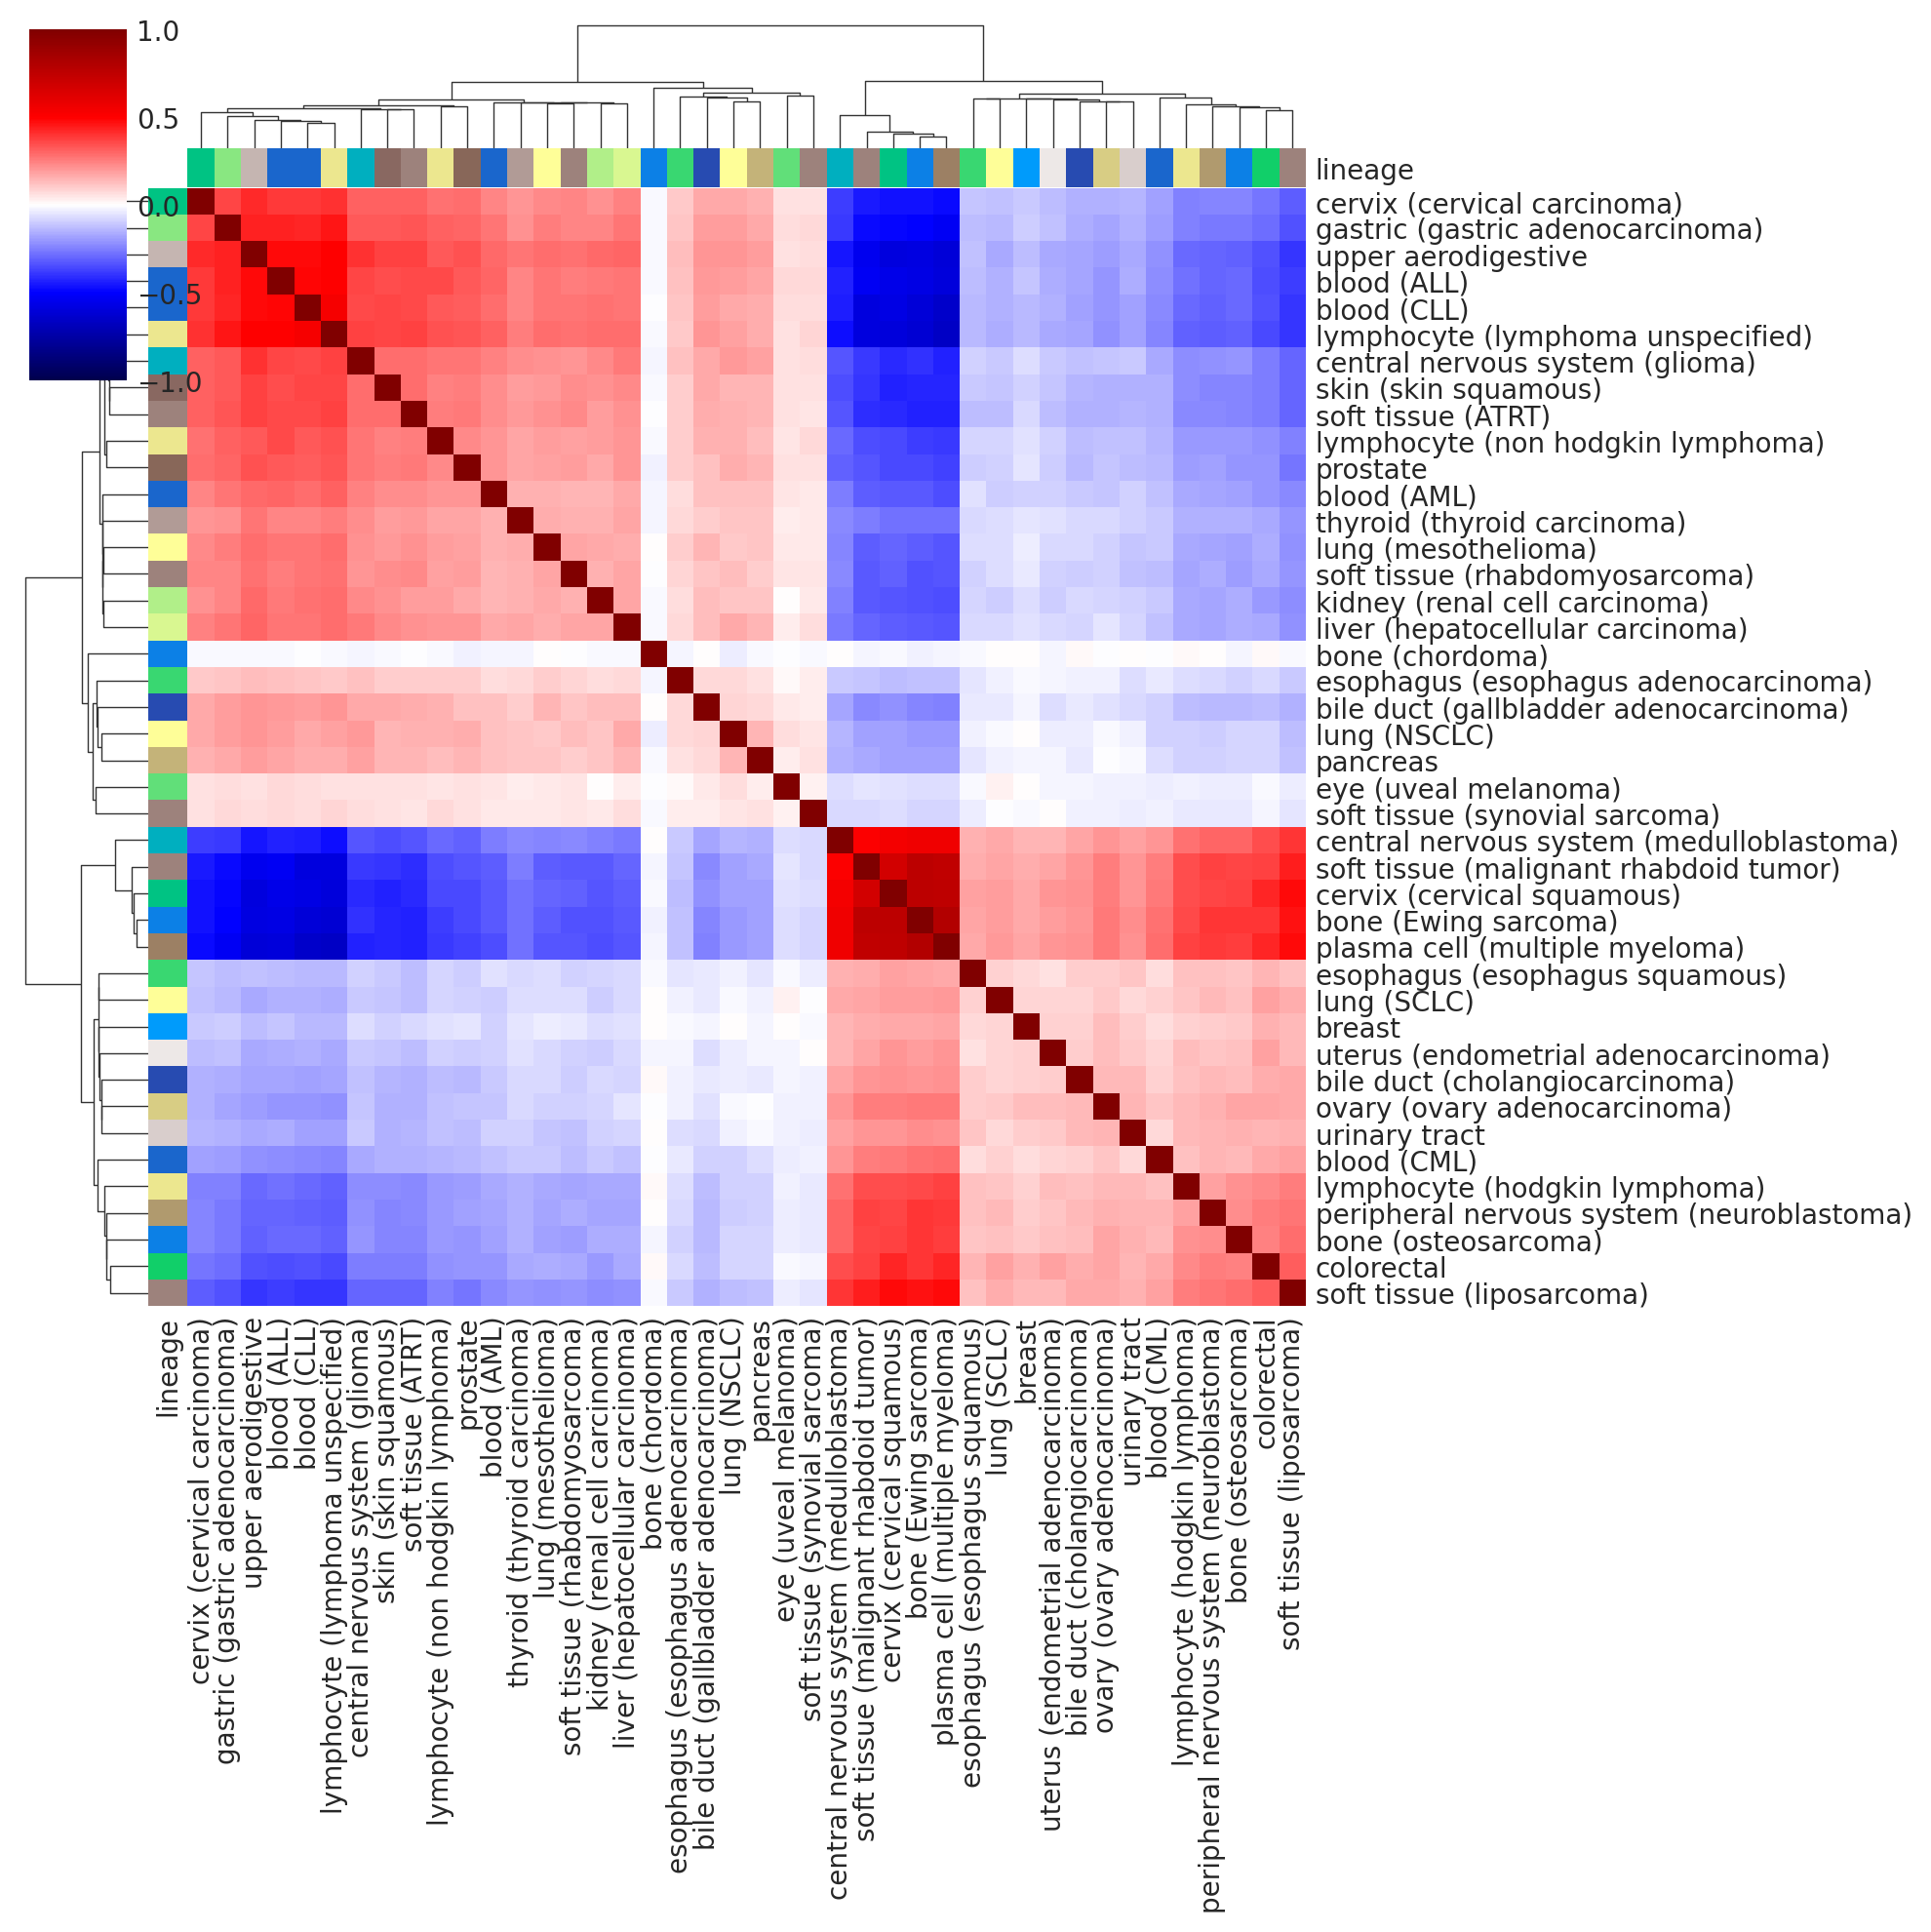

variable: 'd'


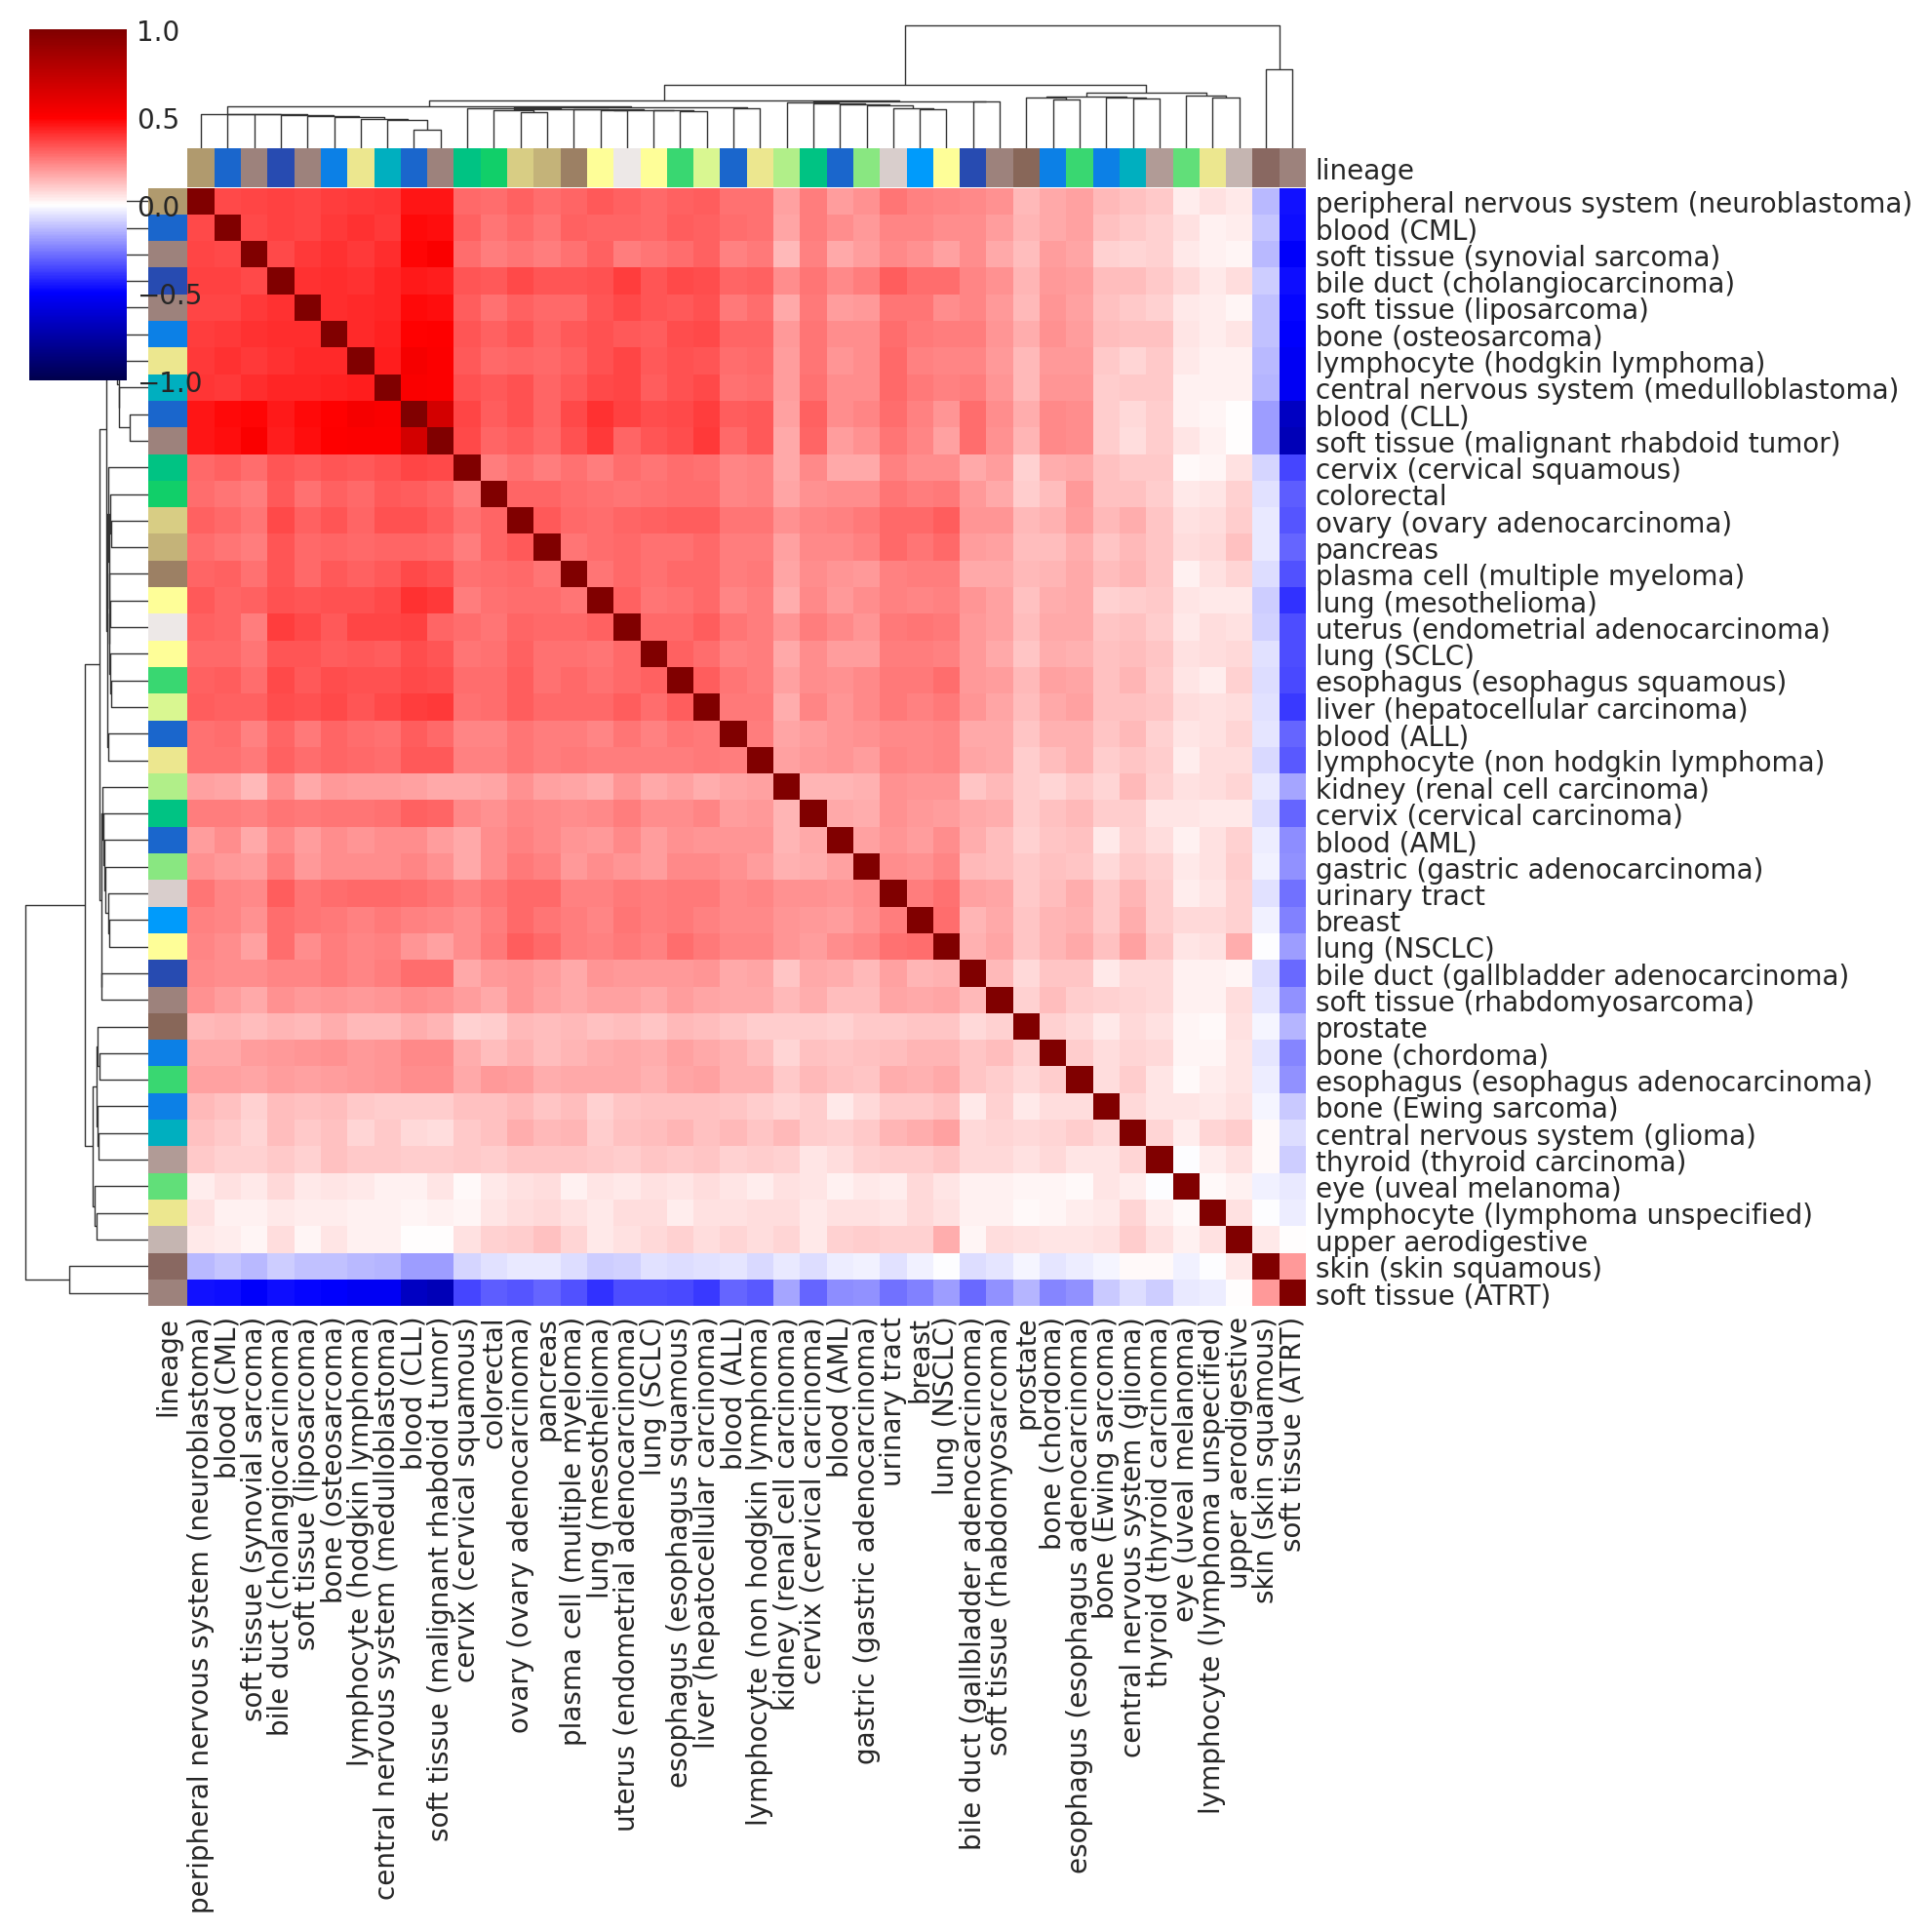

In [47]:
for v in ["b", "d"]:
    print(f"variable: '{v}'")
    X = (
        rna_cn_posterior.query(f"var_name == '{v}'")
        .reset_index(drop=True)
        .pivot_wider(["hugo_symbol"], names_from="lineage_subtype", values_from="mean")
        .corr(method="spearman")
    )

    colors = (
        pd.DataFrame({"lineage_subtype": X.index.tolist()})
        .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
        .assign(lineage=lambda d: d["lineage"].map(lineage_pal))
        .set_index("lineage_subtype")
    )

    sns.clustermap(
        X,
        figsize=(10, 10),
        dendrogram_ratio=(0.1, 0.1),
        xticklabels=1,
        yticklabels=1,
        cmap="seismic",
        row_colors=colors,
        col_colors=colors,
        center=0,
        vmin=-1,
        vmax=1,
    )
    plt.show()

### Cell lines

In [48]:
cell_effects = (
    pd.concat(
        [
            get_variables_posterior_summary(pm, var_names=["mu_k", "mu_m"])
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, col="parameter", names="depmap_id")
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
)
cell_effects.head(3)

No posterior summary for 'skin (melanoma)'.


parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  mu_k[ACH-000182] -0.024  0.022    -0.057      0.013      0.001    0.001   
1  mu_k[ACH-000209]  0.055  0.022     0.022      0.092      0.001    0.001   
2  mu_k[ACH-000377] -0.051  0.022    -0.082     -0.014      0.001    0.001   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0     476.0     944.0   1.00     mu_k  bile duct (cholangiocarcinoma)   
1     415.0    1040.0   1.01     mu_k  bile duct (cholangiocarcinoma)   
2     462.0     964.0   1.01     mu_k  bile duct (cholangiocarcinoma)   

    depmap_id    lineage  
0  ACH-000182  bile duct  
1  ACH-000209  bile duct  
2  ACH-000377  bile duct

In [49]:
chrom_effects = (
    pd.concat(
        [
            get_variables_posterior_summary(pm, var_names=["k", "m"])
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, col="parameter", names="cell_chrom")
    .assign(
        depmap_id=lambda d: [c.split("__")[0] for c in d["cell_chrom"]],
        sgrna_target_chr=lambda d: [c.split("__")[1] for c in d["cell_chrom"]],
    )
    .pipe(map_subtype_to_lineage, st_map=sub_to_lineage)
)
chrom_effects.head(3)

No posterior summary for 'skin (melanoma)'.


parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  k[ACH-000182__1]  0.058  0.021     0.025      0.091      0.001    0.001   
1  k[ACH-000182__2] -0.045  0.022    -0.079     -0.010      0.001    0.001   
2  k[ACH-000182__3] -0.025  0.022    -0.059      0.011      0.001    0.001   

   ess_bulk  ess_tail  r_hat var_name                 lineage_subtype  \
0     409.0     930.0   1.01        k  bile duct (cholangiocarcinoma)   
1     458.0    1026.0   1.01        k  bile duct (cholangiocarcinoma)   
2     487.0     868.0   1.01        k  bile duct (cholangiocarcinoma)   

      cell_chrom   depmap_id sgrna_target_chr    lineage  
0  ACH-000182__1  ACH-000182                1  bile duct  
1  ACH-000182__2  ACH-000182                2  bile duct  
2  ACH-000182__3  ACH-000182                3  bile duct

In [50]:
cell_effects.to_csv(OUTPUT_DIR / "cell-effects.csv", index=False)
chrom_effects.to_csv(OUTPUT_DIR / "chromosome-effects.csv", index=False)

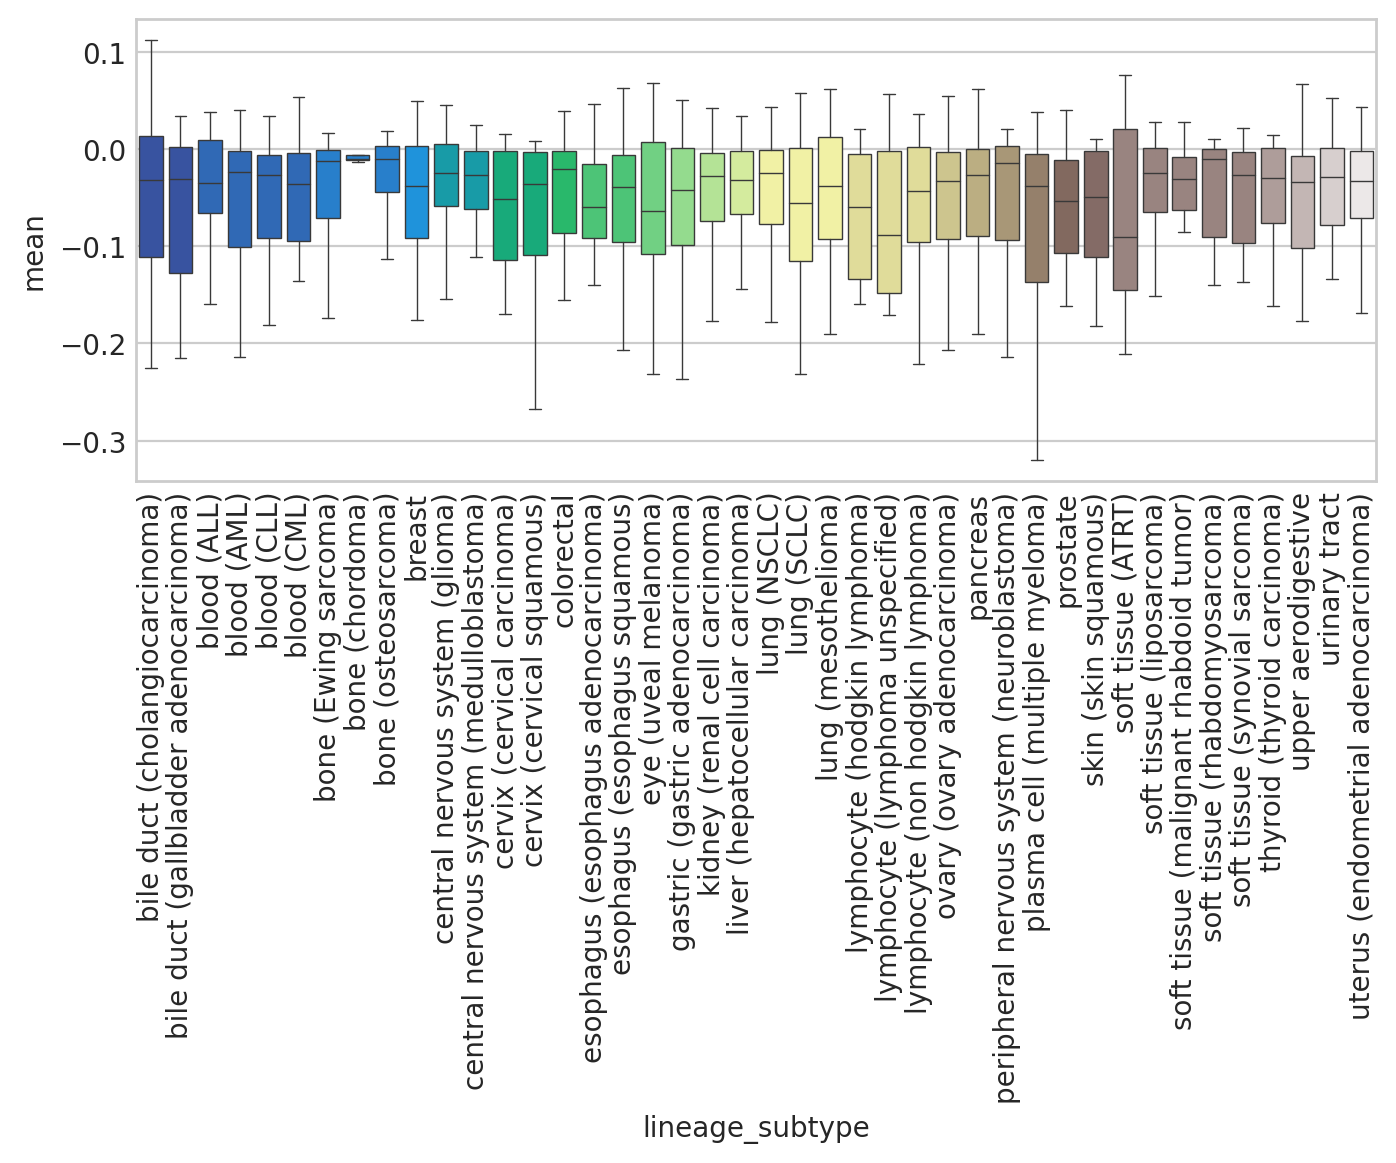

In [51]:
_, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(
    data=cell_effects,
    x="lineage_subtype",
    y="mean",
    hue="lineage",
    palette=lineage_pal,
    dodge=False,
    ax=ax,
    showfliers=False,
    linewidth=0.5,
)
ax.get_legend().remove()
ax.tick_params("x", rotation=90)
plt.show()

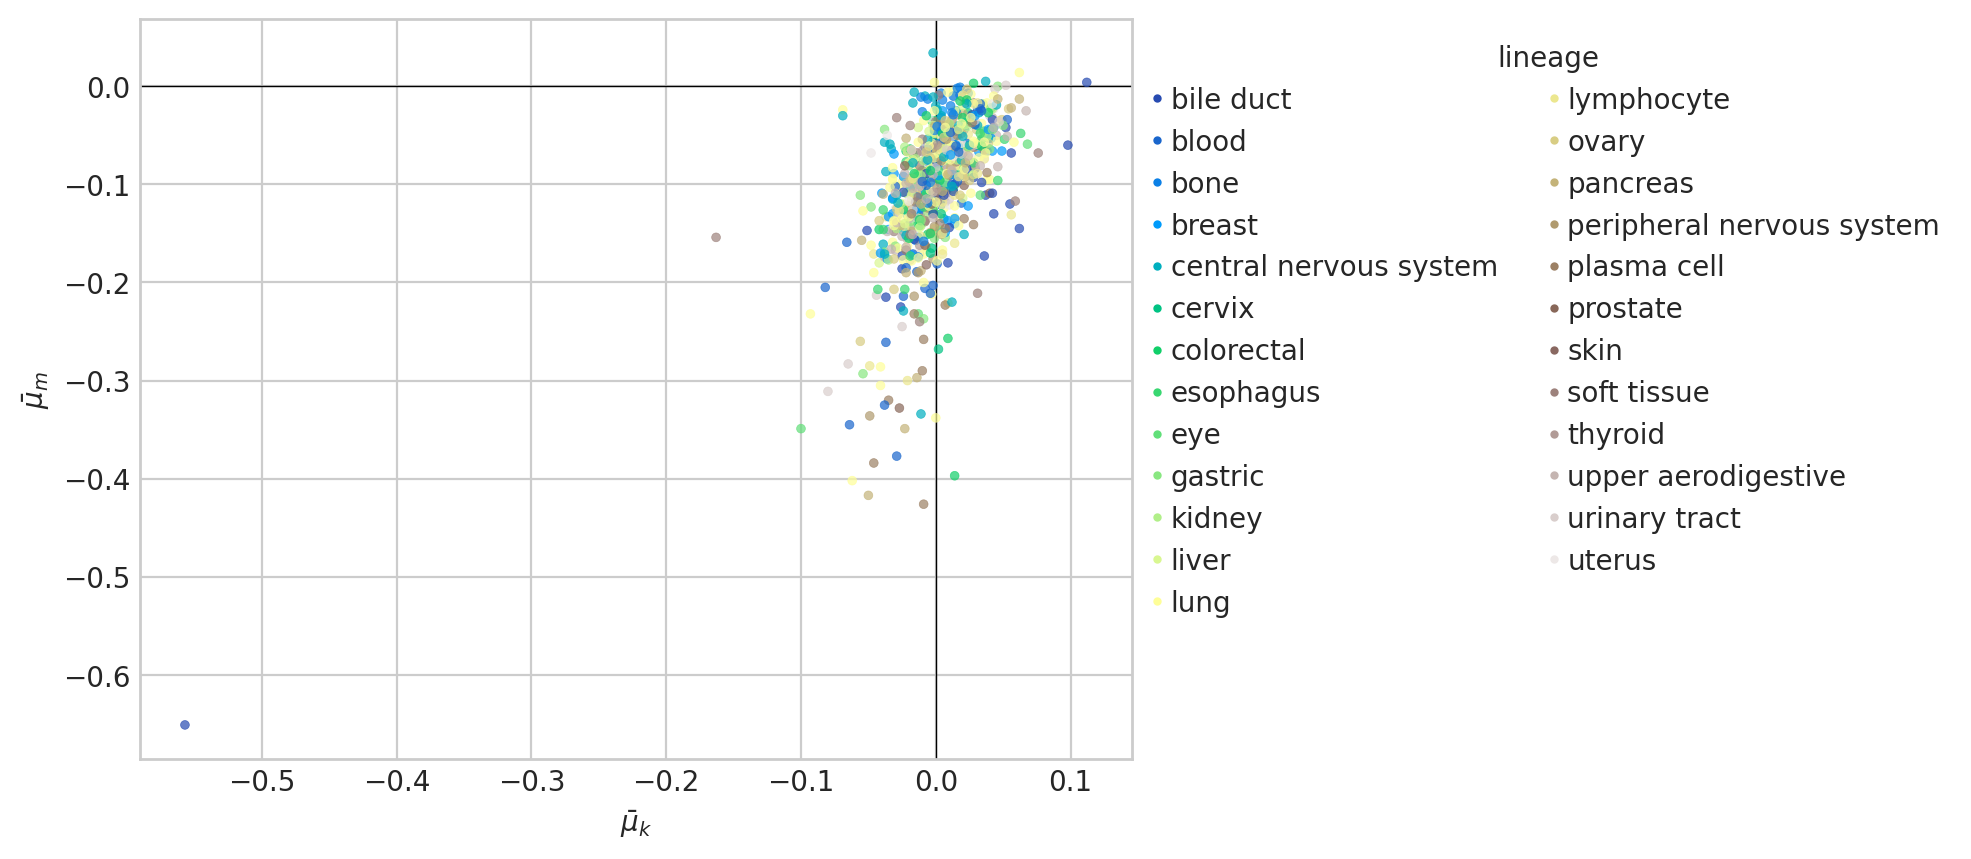

In [52]:
cell_effects_wide = cell_effects.pivot_wider(
    ["depmap_id", "lineage", "lineage_subtype"],
    names_from="var_name",
    values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
)

ax = sns.scatterplot(
    data=cell_effects_wide.sample(frac=1, random_state=12),
    x="mean_mu_k",
    y="mean_mu_m",
    hue="lineage",
    palette=lineage_pal,
    edgecolor=None,
    s=10,
    alpha=0.7,
    legend=False,
    zorder=10,
)
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)
ax.legend(
    handles=pal_to_legend_handles(lineage_pal, lw=0, marker="o", markersize=2),
    title="lineage",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handlelength=0,
    handletextpad=0.5,
    ncol=2,
)
ax.set_xlabel(r"$\bar{\mu}_k$")
ax.set_ylabel(r"$\bar{\mu}_m$")
plt.show()

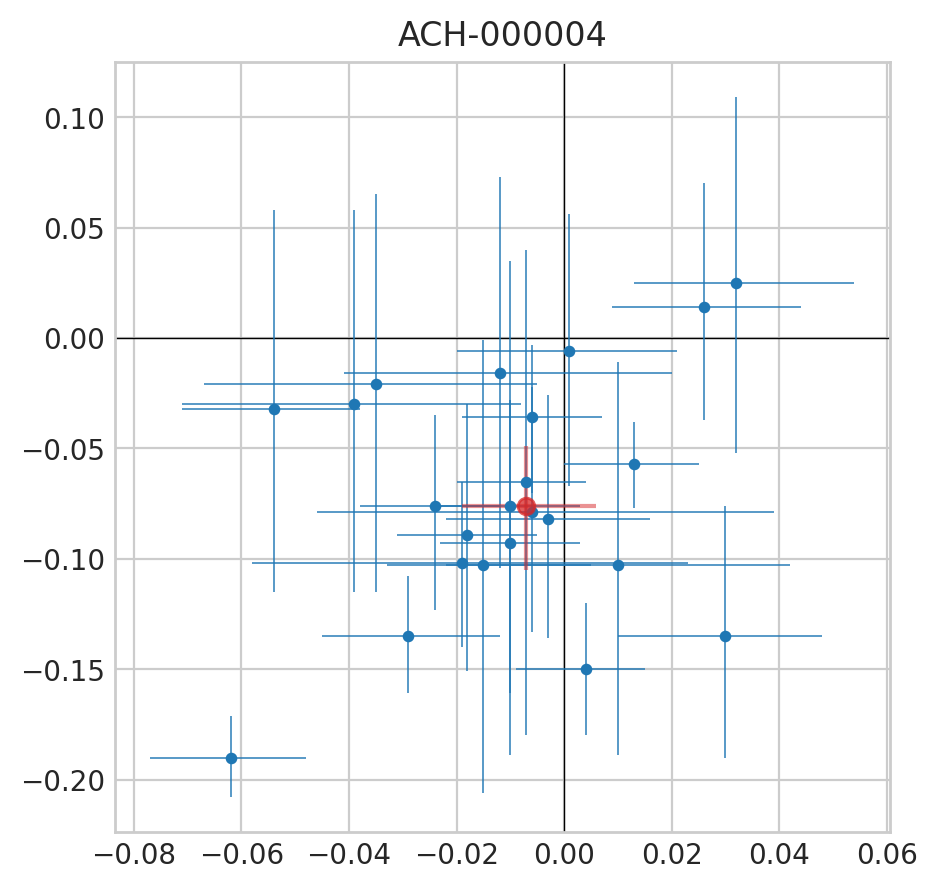

In [53]:
CELLLINE = cell_effects_wide["depmap_id"].unique()[0]

cell_line_avgs = cell_effects_wide.query(f"depmap_id == '{CELLLINE}'")

chrom_effects_wide = chrom_effects.query(f"depmap_id == '{CELLLINE}'").pivot_wider(
    ["sgrna_target_chr"],
    names_from="var_name",
    values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
)

_, ax = plt.subplots(figsize=(5, 5))
ax.set_title(CELLLINE)
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)

x = chrom_effects_wide["mean_k"]
y = chrom_effects_wide["mean_m"]
lines_kwargs = {"lw": 0.7, "alpha": 0.75, "color": "tab:blue"}
ax.vlines(
    x=x,
    ymin=chrom_effects_wide["hdi_5.5%_m"],
    ymax=chrom_effects_wide["hdi_94.5%_m"],
    **lines_kwargs,
    zorder=1,
)
ax.hlines(
    y=y,
    xmin=chrom_effects_wide["hdi_5.5%_k"],
    xmax=chrom_effects_wide["hdi_94.5%_k"],
    **lines_kwargs,
    zorder=1,
)

ax.scatter(
    x=cell_line_avgs["mean_mu_k"],
    y=cell_line_avgs["mean_mu_m"],
    c="tab:red",
    zorder=20,
    alpha=0.75,
)

lines_kwargs = {"lw": 1.5, "alpha": 0.5, "color": "tab:red"}
ax.vlines(
    x=cell_line_avgs["mean_mu_k"],
    ymin=cell_line_avgs["hdi_5.5%_mu_m"],
    ymax=cell_line_avgs["hdi_94.5%_mu_m"],
    **lines_kwargs,
    zorder=1,
)
ax.hlines(
    y=cell_line_avgs["mean_mu_m"],
    xmin=cell_line_avgs["hdi_5.5%_mu_k"],
    xmax=cell_line_avgs["hdi_94.5%_mu_k"],
    **lines_kwargs,
    zorder=1,
)

ax.scatter(x, y, s=10, zorder=10)
plt.show()

variable: 'k'


/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


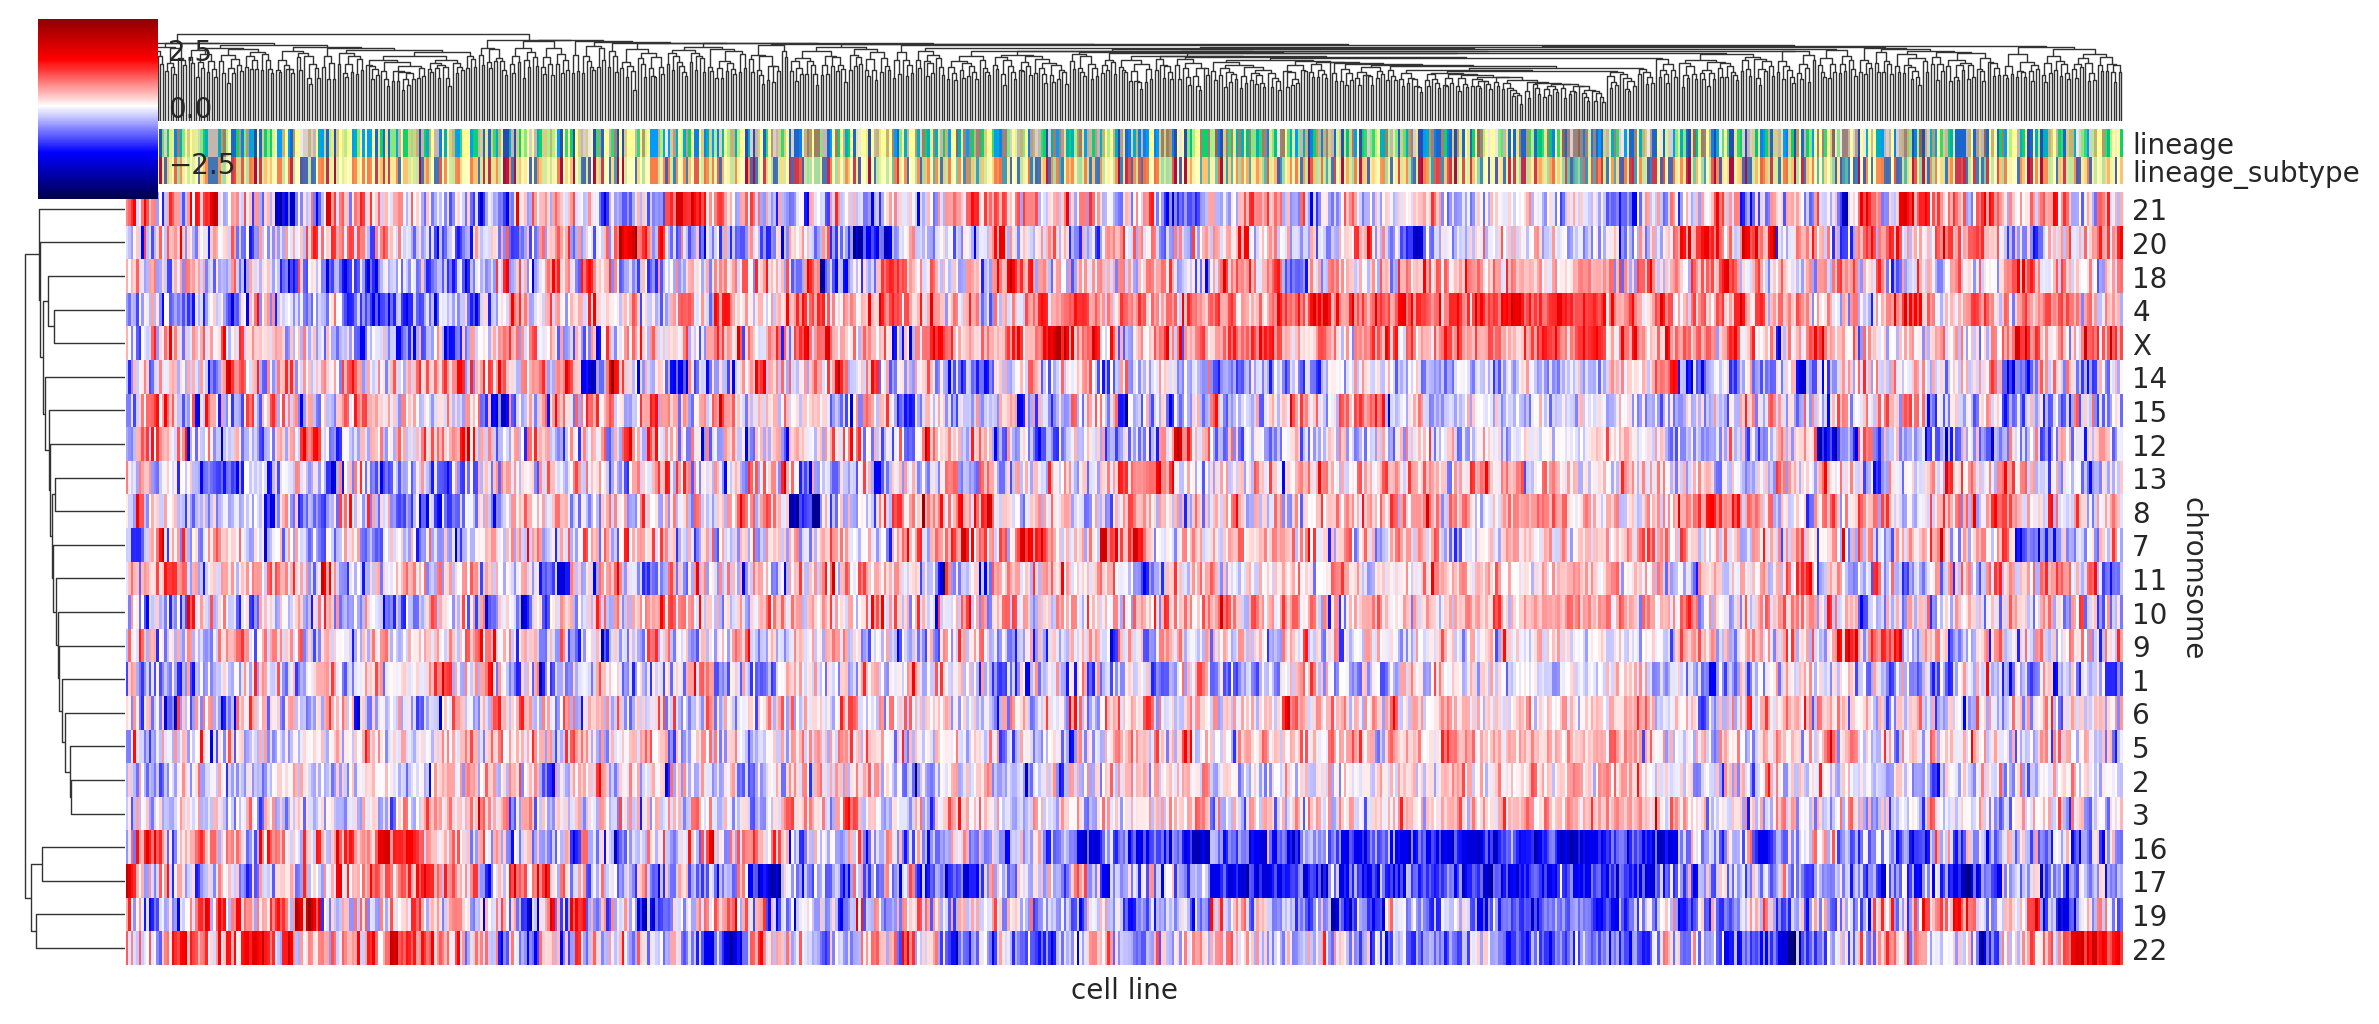

variable: 'm'


/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


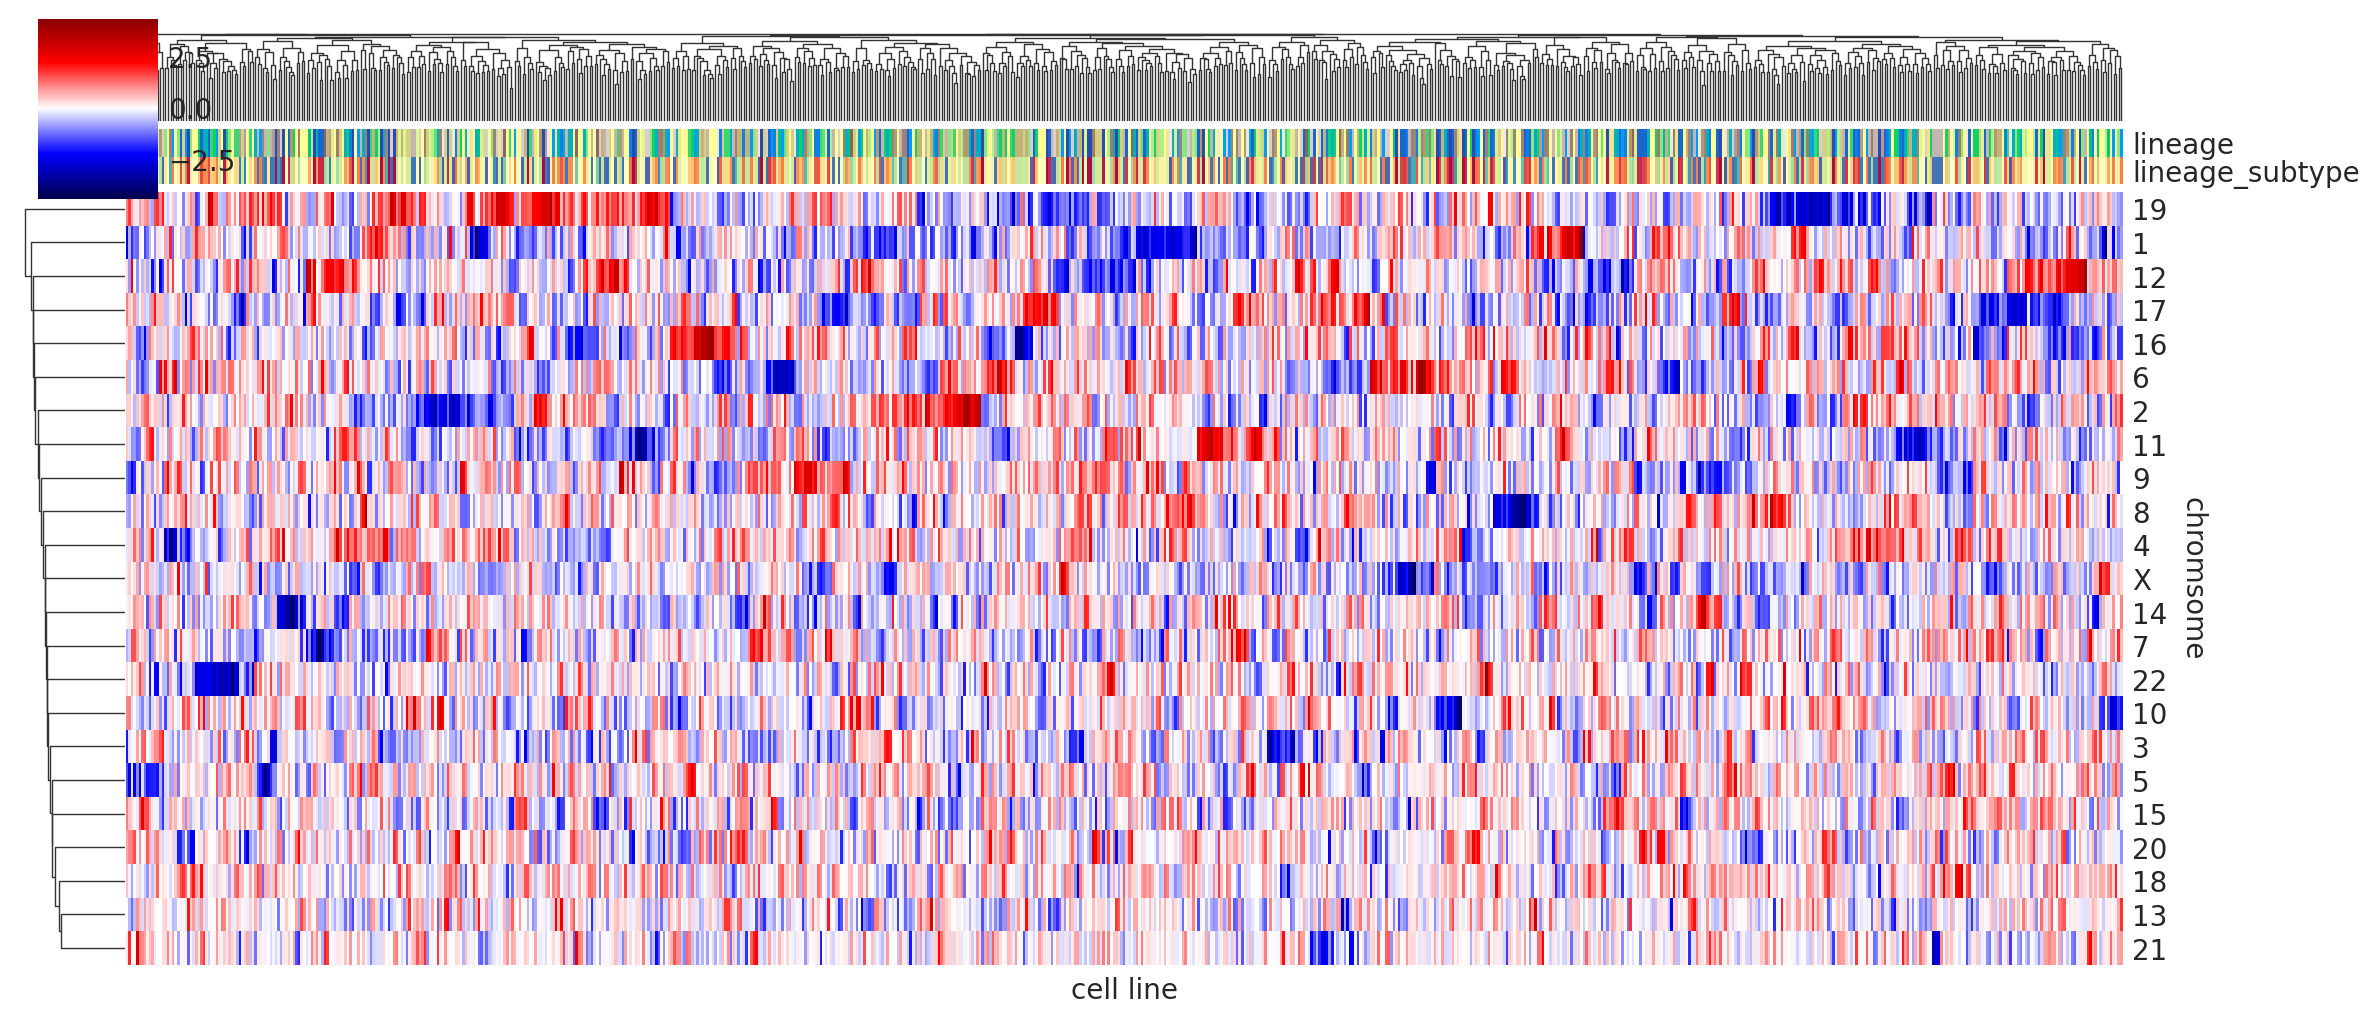

In [54]:
for var_name in ["k", "m"]:
    print(f"variable: '{var_name}'")
    cell_chrom_X = (
        chrom_effects.query(f"var_name == '{var_name}'")
        .pivot_wider(["sgrna_target_chr"], names_from="depmap_id", values_from="mean")
        .set_index("sgrna_target_chr")
    )

    cell_chrom_col_colors = (
        chrom_effects[["depmap_id", "lineage", "lineage_subtype"]]
        .drop_duplicates()
        .set_index("depmap_id")
        .assign(
            lineage=lambda d: d["lineage"].map(lineage_pal),
            lineage_subtype=lambda d: d["lineage_subtype"].map(sublineage_pal),
        )
    )

    cg = sns.clustermap(
        cell_chrom_X,
        cmap="seismic",
        z_score=1,
        center=0,
        # vmin=-0.5,
        # vmax=0.5,
        figsize=(12, 5),
        yticklabels=1,
        col_colors=cell_chrom_col_colors,
        xticklabels=False,
        dendrogram_ratio=(0.05, 0.1),
    )
    cg.ax_heatmap.set_xlabel("cell line")
    cg.ax_heatmap.set_ylabel("chromsome", rotation=270, va="bottom")
    plt.show()

### Compare effects on X chromosome by sex

#### Comparing posterior summaries

In [55]:
cell_line_info = pd.read_csv(data_path(DataFile.DEPMAP_CELL_LINE_INFO)).query(
    "screen == 'broad'"
)

sex_lbls = {True: "M", False: "F", np.nan: "unk."}

cell_line_sex = cell_line_info.assign(sex=lambda d: d["is_male"].map(sex_lbls))[
    ["depmap_id", "sex"]
].drop_duplicates()
cell_line_sex.to_csv(OUTPUT_DIR / "cell-line-sexes.csv")

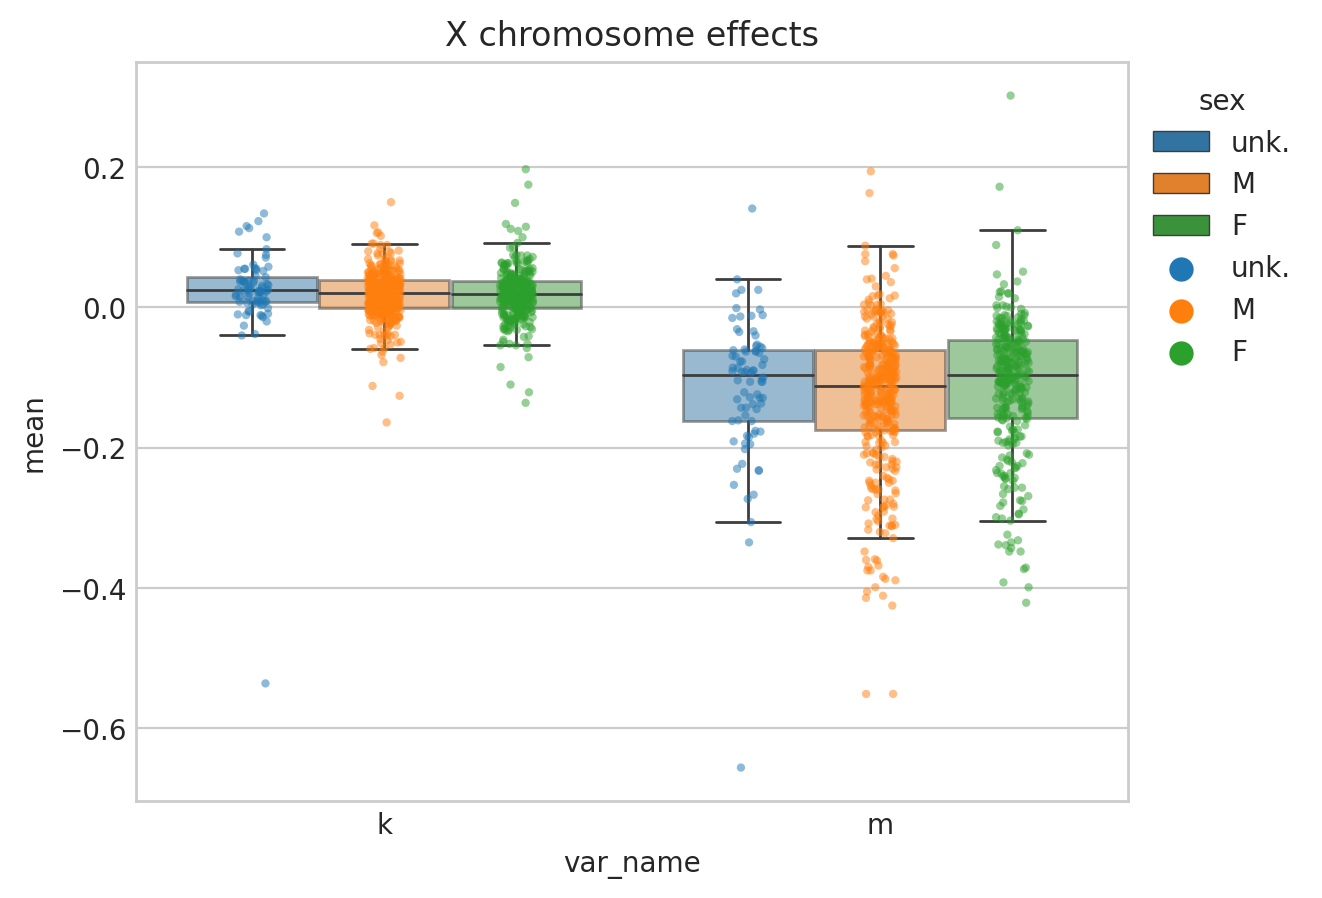

In [56]:
sex_chrom_effects = chrom_effects.query("sgrna_target_chr == 'X'").merge(
    cell_line_sex, on="depmap_id"
)
ax = sns.boxplot(
    data=sex_chrom_effects,
    x="var_name",
    y="mean",
    hue="sex",
    showfliers=False,
    linewidth=1,
    boxprops={"alpha": 0.5},
)
sns.stripplot(
    data=sex_chrom_effects,
    x="var_name",
    y="mean",
    hue="sex",
    dodge=True,
    s=3,
    alpha=0.5,
    ax=ax,
)
ax.legend(title="sex", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("X chromosome effects")
plt.show()

In [57]:
sex_chrom_effects.to_csv(OUTPUT_DIR / "sex-chromosome-differences.csv", index=False)

#### Comparing posterior draws

In [58]:
def x_chromsome_sex_comparison(
    pm: PostDataMan, sex_info: pd.DataFrame, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"x-chrom-comparison-{pm.id}.csv"

    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    try:
        trace = pm.trace
    except AssertionError:
        print(f"No trace for {pm.id}.")
        return pd.DataFrame()

    cells = trace.posterior.coords.get("cell_line").values
    sexes = (
        cell_line_sex.copy()
        .filter_column_isin("depmap_id", cells)
        .filter_column_isin("sex", ["M", "F"])
        .drop_duplicates()
    )

    if sexes["sex"].nunique() < 2:
        print(f"Not both sexes for {pm.id}.")
        return pd.DataFrame()

    sex_chrom_diff: pd.DataFrame | None = None
    for var in ["k", "m"]:
        F_cells = sexes.query("sex == 'F'")["depmap_id"].tolist()
        F_chroms = [f"{c}__X" for c in F_cells]
        F_avgs = trace.posterior.get(var).sel(cell_chrom=F_chroms).mean(axis=(2))

        M_cells = sexes.query("sex == 'M'")["depmap_id"].tolist()
        M_chroms = [f"{c}__X" for c in M_cells]
        M_avgs = trace.posterior.get(var).sel(cell_chrom=M_chroms).mean(axis=(2))

        res = (M_avgs - F_avgs).to_dataframe()
        if sex_chrom_diff is None:
            sex_chrom_diff = res
        else:
            sex_chrom_diff = sex_chrom_diff.merge(
                res, left_index=True, right_index=True
            )

    assert sex_chrom_diff is not None
    sex_chrom_diff = sex_chrom_diff.reset_index(drop=False).assign(
        lineage_subtype=pm.id
    )
    sex_chrom_diff.to_csv(stash_fp, index=False)
    return sex_chrom_diff

In [59]:
x_chrom_comparisons = pd.concat(
    [x_chromsome_sex_comparison(pm, cell_line_sex) for pm in postmen.posteriors]
).reset_index(drop=True)

Not both sexes for blood (CLL).
Not both sexes for breast.
Not both sexes for cervix (cervical carcinoma).
Not both sexes for cervix (cervical squamous).
Not both sexes for ovary (ovary adenocarcinoma).
Not both sexes for prostate.
No trace for skin (melanoma).
Not both sexes for soft tissue (liposarcoma).
Not both sexes for soft tissue (synovial sarcoma).
Not both sexes for uterus (endometrial adenocarcinoma).


In [60]:
x_chrom_comparisons.head()

chain  draw         k         m                 lineage_subtype
0      0     0  0.007834 -0.031695  bile duct (cholangiocarcinoma)
1      0     1  0.012195 -0.008549  bile duct (cholangiocarcinoma)
2      0     2  0.017923  0.000096  bile duct (cholangiocarcinoma)
3      0     3  0.015091 -0.027006  bile duct (cholangiocarcinoma)
4      0     4  0.008400 -0.054511  bile duct (cholangiocarcinoma)

In [61]:
x_chrom_comparisons.to_csv(OUTPUT_DIR / "X-chrom-difference-draws.csv")

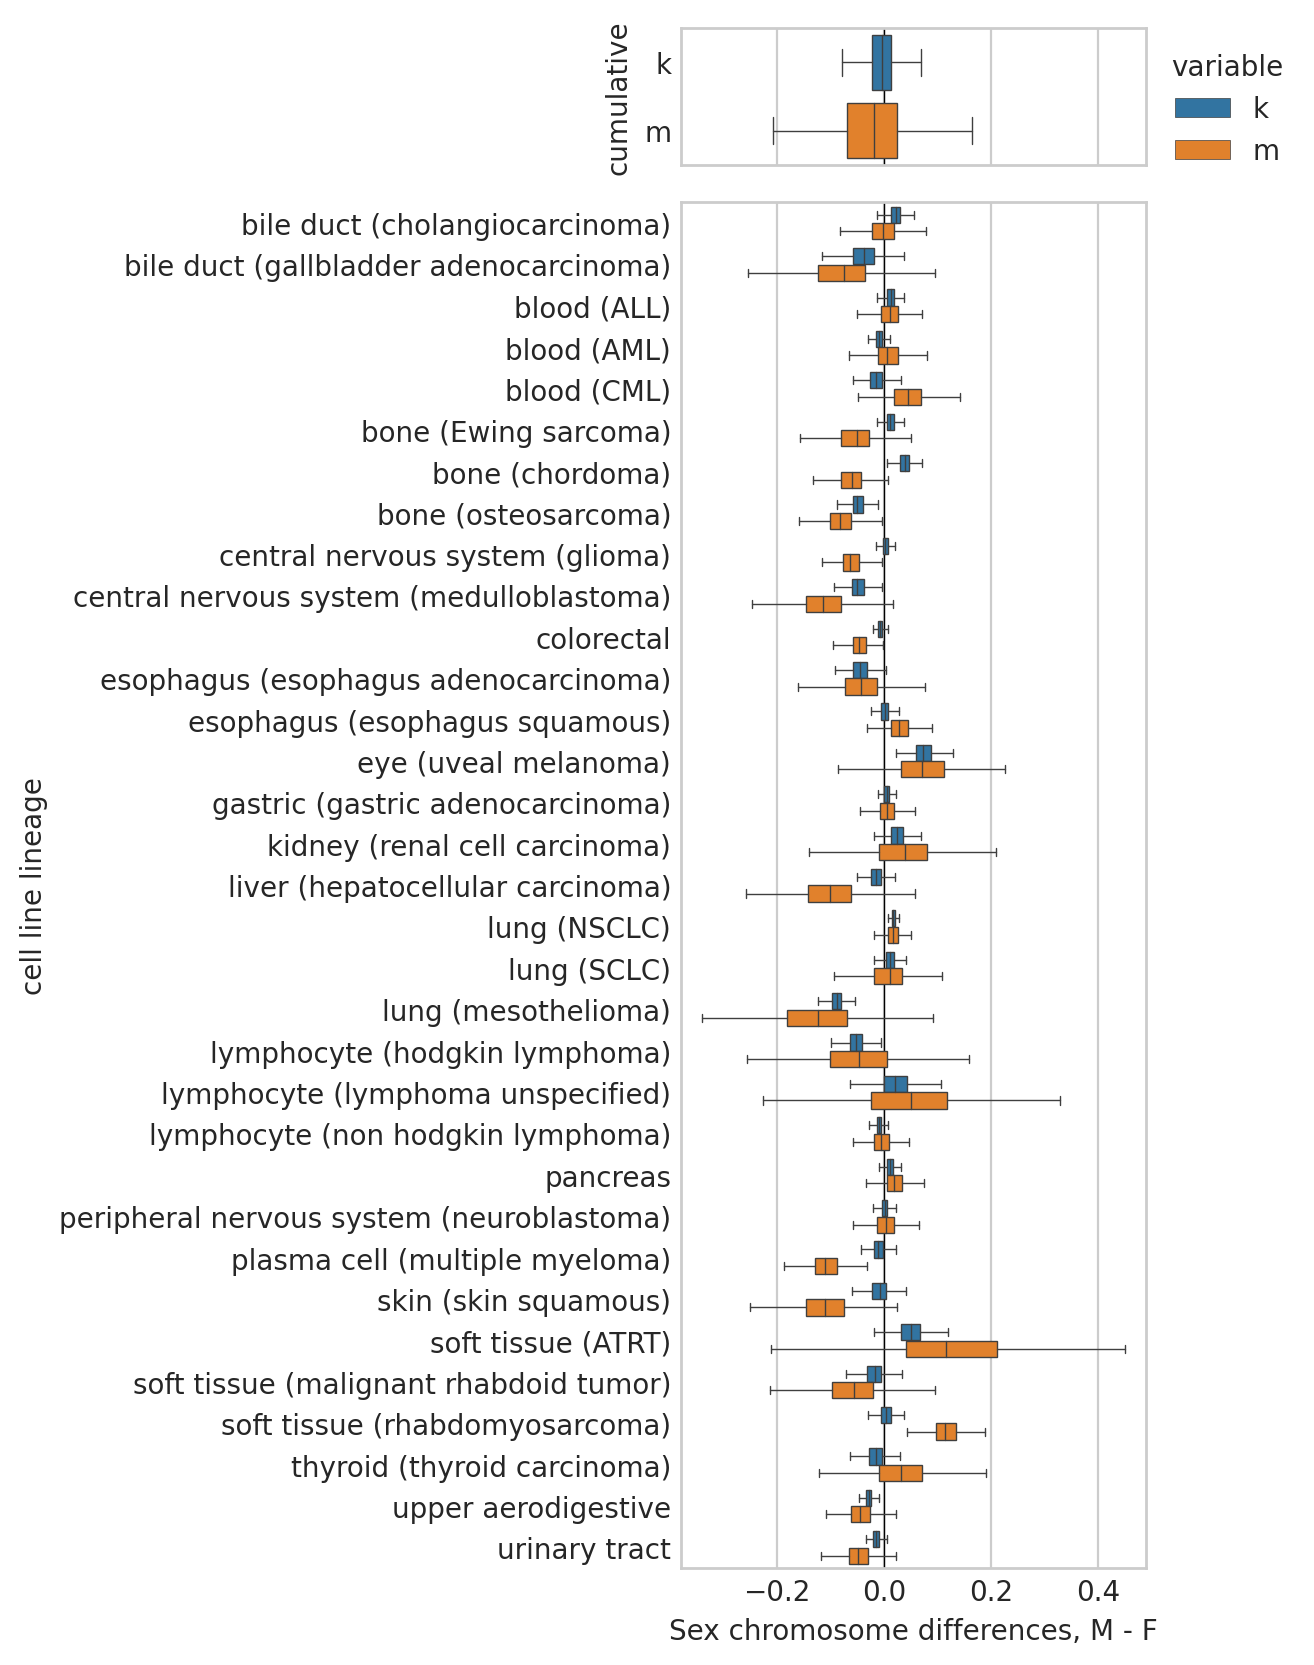

In [62]:
def labels_with_num_sexes(lbl: Text, tp53_df: pd.DataFrame, pm: PostDataMan) -> Text:
    t = lbl.get_text()
    cells = list(pm.trace.posterior.coords.get("cell_line").values)
    n_tp53_muts = (
        tp53_df.query("tp53_null")
        .filter_column_isin("depmap_id", cells)["depmap_id"]
        .nunique()
    )

    if "(" in t:
        t = t.split("(")[1].replace(")", "").strip()

    t = f"{t} ({n_tp53_muts})"
    lbl.set_text(t)
    return lbl


plot_df = (
    x_chrom_comparisons.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["k", "m"])
)

fig, axes = plt.subplots(
    nrows=2,
    figsize=(3, 10),
    sharex=True,
    gridspec_kw={"height_ratios": (1, 10), "hspace": 0.05},
)

ax = axes[0]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="variable",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    dodge=False,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.set_xlabel(None)
ax.set_ylabel("cumulative")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="variable")

ax = axes[1]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="lineage_subtype",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.get_legend().remove()

# xlbls = [
#     labels_with_num_tp53_muts(lbl, tp53_data, postmen[lbl.get_text()])
#     for lbl in ax.get_yticklabels()
# ]
# ax.set_yticklabels(labels=xlbls)
# ax.set_xlim(-0.2, 0.2)
ax.set_ylabel("cell line lineage")
ax.set_xlabel("Sex chromosome differences, M - F")

plt.show()

### TP53 mutants vs WT cell line effects

#### Comparing posterior summaries

In [63]:
def _get_tp53_data(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"tp53-raw-data_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    tp53_genes = ["TP53", "MDM2"]
    res = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            usecols=[
                "lineage",
                "lineage_subtype",
                "depmap_id",
                "hugo_symbol",
                "is_mutated",
                "copy_number",
                "rna_expr",
            ],
            dtype={"rna_expr": "float64"},
        )
        .query("hugo_symbol in @genes", local_dict={"genes": tp53_genes})
        .drop_duplicates()
        .compute()
        .reset_index(drop=True)
    )
    res.to_csv(stash_fp, index=False)
    return res

In [64]:
tp53_data = (
    pd.concat([_get_tp53_data(pm) for pm in postmen.posteriors])
    .reset_index(drop=True)
    .query("hugo_symbol == 'TP53'")
    .reset_index(drop=True)
    .assign(copy_number=lambda d: (2 ** d["copy_number"]) - 1)
)
tp53_data.head()

hugo_symbol   depmap_id  rna_expr  is_mutated  copy_number  \
0        TP53  ACH-000182  4.390255       False     0.561240   
1        TP53  ACH-000209  5.741467       False     1.363992   
2        TP53  ACH-000377  2.805292        True     0.714892   
3        TP53  ACH-000461  7.486553        True     0.838891   
4        TP53  ACH-000976  4.944390        True     0.896567   

      lineage_subtype                         lineage  
0  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
1  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
2  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
3  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)  
4  cholangiocarcinoma  bile_duct_(cholangiocarcinoma)

In [65]:
tp53_is_mut = []
for _, row in tp53_data.iterrows():
    if row["is_mutated"]:
        tp53_is_mut.append(True)
    elif row["copy_number"] < 0.5:
        tp53_is_mut.append(True)
    elif row["rna_expr"] < 0.0:
        tp53_is_mut.append(True)
    else:
        tp53_is_mut.append(False)

tp53_data["tp53_null"] = tp53_is_mut

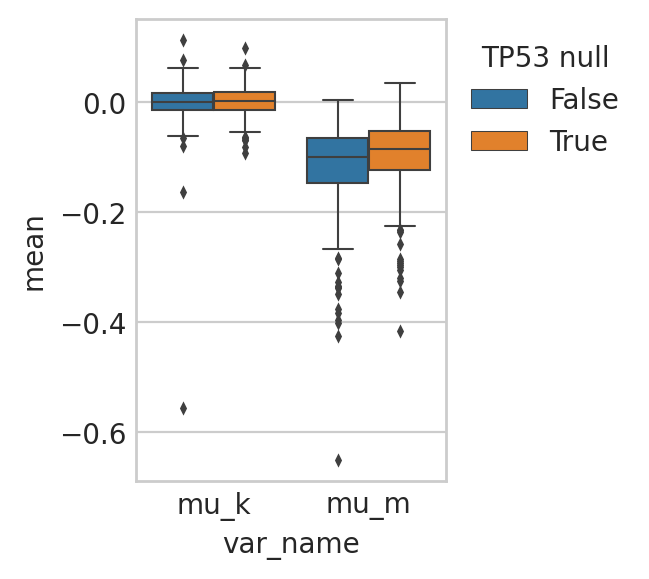

In [66]:
cell_effects_tp53 = cell_effects.merge(
    tp53_data[["depmap_id", "tp53_null"]], on="depmap_id", how="left"
)

plt_df = cell_effects_tp53.copy().reset_index(drop=True)
_cats = (
    plt_df[["lineage", "tp53_null"]]
    .drop_duplicates()
    .groupby("lineage")["tp53_null"]
    .count()
)
_keep_lineages = _cats[_cats > 1].index.tolist()
plt_df = plt_df.filter_column_isin("lineage", _keep_lineages)

_, ax = plt.subplots(figsize=(2, 3))
sns.boxplot(
    data=plt_df,
    x="var_name",
    y="mean",
    hue="tp53_null",
    linewidth=0.75,
    dodge=True,
    fliersize=2,
    ax=ax,
)
ax.legend(title="TP53 null", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [67]:
cell_effects_tp53.to_csv(OUTPUT_DIR / "tp53-mutation-effects.csv", index=False)
tp53_data.to_csv(OUTPUT_DIR / "tp53-mutation-data.csv", index=False)

#### Comparing posterior draws

In [68]:
def tp53_mut_wt_comparison(
    pm: PostDataMan, tp53_muts: pd.DataFrame, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"posterior-dist-tp53-mut-wt_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    try:
        trace = pm.trace
    except AssertionError:
        print(f"No posterior for '{pm.id}.'")
        return pd.DataFrame()

    cells = list(trace.posterior.coords.get("cell_line").values)
    tp53 = tp53_muts.filter_column_isin("depmap_id", cells)[
        ["depmap_id", "tp53_null"]
    ].set_index("depmap_id")
    tp53_mut_idx = tp53.loc[cells]["tp53_null"].values

    if np.all(tp53_mut_idx) or not np.any(tp53_mut_idx):
        print(f"Skipping '{pm.id}'.")
        return pd.DataFrame()

    res: pd.DataFrame | None = None
    for v in ["mu_k", "mu_m"]:
        var = trace.posterior.get(v)
        muts = var[:, :, tp53_mut_idx].mean(axis=(2))
        wts = var[:, :, ~tp53_mut_idx].mean(axis=(2))
        mut_wt_diff = (muts - wts).to_dataframe()
        if res is None:
            res = mut_wt_diff
        else:
            res = res.merge(mut_wt_diff, left_index=True, right_index=True)

    assert res is not None
    res = res.reset_index(drop=False).assign(lineage_subtype=pm.id)
    res.to_csv(stash_fp, index=False)
    return res

In [69]:
tp53_draw_diffs = pd.concat(
    [tp53_mut_wt_comparison(pm, tp53_data.copy()) for pm in postmen.posteriors]
).reset_index(drop=True)

Skipping 'blood (CML)'.
Skipping 'esophagus (esophagus adenocarcinoma)'.
Skipping 'esophagus (esophagus squamous)'.
Skipping 'eye (uveal melanoma)'.
Skipping 'lung (SCLC)'.
No posterior for 'skin (melanoma).'
Skipping 'soft tissue (malignant rhabdoid tumor)'.
Skipping 'thyroid (thyroid carcinoma)'.


In [70]:
tp53_draw_diffs.to_csv(OUTPUT_DIR / "tp53-difference-draws.csv")

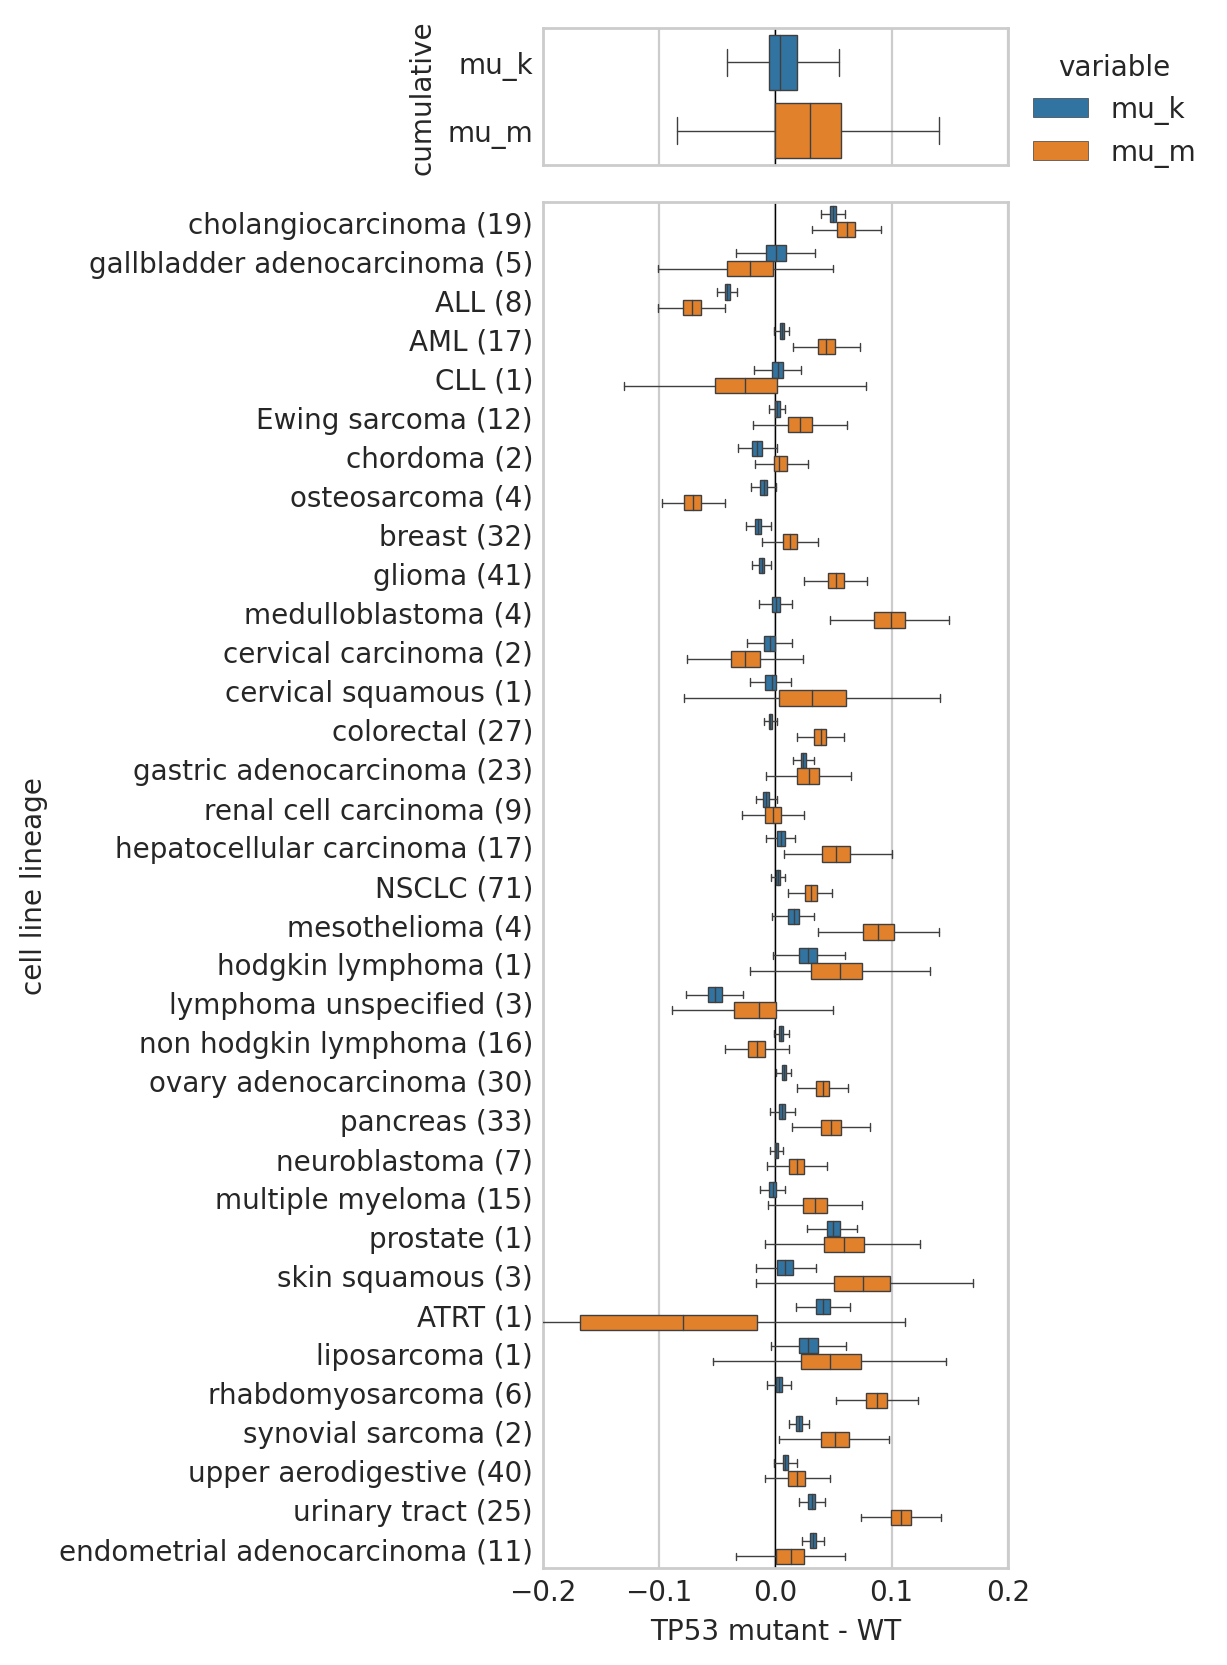

In [71]:
def labels_with_num_tp53_muts(
    lbl: Text, tp53_df: pd.DataFrame, pm: PostDataMan
) -> Text:
    t = lbl.get_text()
    cells = list(pm.trace.posterior.coords.get("cell_line").values)
    n_tp53_muts = (
        tp53_df.query("tp53_null")
        .filter_column_isin("depmap_id", cells)["depmap_id"]
        .nunique()
    )

    if "(" in t:
        t = t.split("(")[1].replace(")", "").strip()

    t = f"{t} ({n_tp53_muts})"
    lbl.set_text(t)
    return lbl


plot_df = (
    tp53_draw_diffs.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["mu_k", "mu_m"])
)

fig, axes = plt.subplots(
    nrows=2,
    figsize=(3, 10),
    sharex=True,
    gridspec_kw={"height_ratios": (1, 10), "hspace": 0.05},
)

ax = axes[0]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="variable",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    dodge=False,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.set_xlabel(None)
ax.set_ylabel("cumulative")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="variable")

ax = axes[1]
ax.axvline(0, c="k", lw=0.5, zorder=1)
sns.boxplot(
    data=plot_df,
    y="lineage_subtype",
    x="value",
    hue="variable",
    linewidth=0.5,
    width=0.8,
    ax=ax,
    showfliers=False,
    zorder=20,
    boxprops={"zorder": 20},
)
ax.get_legend().remove()

xlbls = [
    labels_with_num_tp53_muts(lbl, tp53_data, postmen[lbl.get_text()])
    for lbl in ax.get_yticklabels()
]
ax.set_yticklabels(labels=xlbls)  # , rotation=60, ha="right")
ax.set_xlim(-0.2, 0.2)
ax.set_ylabel("cell line lineage")
ax.set_xlabel("TP53 mutant - WT")

plt.show()

---

In [72]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 8.67 minutes


In [73]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-04

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: figures

json      : 2.0.9
seaborn   : 0.11.2
matplotlib: 3.5.3
dask      : 2022.9.0
pandas    : 1.4.4
numpy     : 1.23.3

